# Import packages

In [1]:
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
import time
from bs4 import BeautifulSoup
import pandas as pd
import re
from datetime import date
from datetime import datetime
from random import randrange
import glob
import os
from tqdm import tqdm_notebook
from tqdm import tqdm
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
import geocoder
import plotly.express as px
import numpy as np
import mpu
import warnings
from scipy import stats

from bokeh.models import *
from bokeh.plotting import *
from bokeh.io import *
from bokeh.tile_providers import *
from bokeh.palettes import *
from bokeh.transform import *
from bokeh.layouts import *

import pickle
import numpy as np
import xgboost as xgb

%matplotlib inline
pd.set_option('display.max_columns', None) #to display all columns

# Read in apartment data
I scraped this data from the biggest hungarian housing website called: ingatlan.com.

You can find it on the following link: [www.ingatlan.com](www.ingatlan.com).

It consist all the apartments that were on the website in December, 2021 from Budapest.

## The colleceted CSV files are in one folder we need to merge them first

In [2]:
folder_name = '../all_apartments_220111'

In [3]:
# setting the path for joining multiple files
files = os.path.join(folder_name, '*.csv')
# list of merged files returned
files_to_join = glob.glob(files)

In [4]:
len(files_to_join) #we have this many files in the folder

30747

In [5]:
def read_in_apartment_data(apt_folder_name = '../all_apartments_211221',
                           base_file = '../base_data20211221_035607.csv',
                           print_duplicate_check = True, save_csv = True):
    
    # Setting the path for joining multiple files
    files = os.path.join(apt_folder_name, '*.csv')
    # List of merged files returned
    files_to_join = glob.glob(files)
    
    apt_data = pd.read_csv(files_to_join[0])
    
    i = 1
    for filename in tqdm(files_to_join[1:], desc = "Progress (read in this many files)"):   
        try:
            new_file_to_add = pd.read_csv(filename)
            apt_data = pd.concat([apt_data, new_file_to_add], ignore_index=True)
        except:
            continue
    
    if print_duplicate_check:
        print("Data row number before duplicate check:")
        print(len(apt_data))
    
    apt_data = apt_data.drop_duplicates(subset=apt_data.columns.difference(['download_time']))
    
    if print_duplicate_check:
        print("Data row number after duplicate check:")
        print(len(apt_data))
    
    # Read in base data  
    base_data = pd.read_csv(base_file)
    
    # Merge apartment scraped data with the base data. 
    # We need to do this because the price and some other metrics are comming from the other table.
    data = pd.merge(apt_data, base_data, left_on= ['link'], right_on=['webpage_all'], how = 'left')
    
    # Drop na
    data = data[data['link'].notna()]
    
    # Rename some variables
    data['Építéséve'] = data['Építéséve'].fillna('nincsmegadva')
    
    if save_csv:
        now = datetime.now()
        dt_string = now.strftime("%Y%m%d_%H%M%S")
        apt_data_filename = '../combined_apt_data_' + str(dt_string) + '.csv'
        data.to_csv(apt_data_filename, encoding='utf-8', index=False)
    
    return(data)

In [6]:
#all_apt = read_in_apartment_data(apt_folder_name = '../all_apartments_220111', base_file = '../base_data20220111_181100.csv',  print_duplicate_check = True, save_csv = True)

In [7]:
all_apt = pd.read_csv('../combined_apt_data_20220113_142854.csv') # I already saved the data so I just read it in

Look at how our data looks like:

Print out one link. This is important to us, since it contains information. Such as district and the type of apartament. We need to create variables using them

In [8]:
random_number = randrange(len(all_apt))
print(random_number)
one_link = all_apt['link'][random_number]
print(one_link)

8239
https://ingatlan.com/vi-ker/elado+lakas/tegla-epitesu-lakas/32153220


In [9]:
all_apt

,Ingatlanállapota,Építéséve,Komfort,Energiatanúsítvány,Emelet,Épületszintjei,Lift,Belmagasság,Fűtés,Légkondicionáló,Rezsiköltség,Akadálymentesített,FürdőésWC,Tájolás,Kilátás,Erkélymérete,Kertkapcsolatos,Tetőtér,Parkolás,Parkolóhelyára,link,error,download_time,Panelprogram,links,prices,adresses,area_sizes,room_numbers,balcony_sizes,webpage_all
0,felújított,1950előtt,luxus,nincsmegadva,2,4,nincs,3mnélmagasabb,gázcirko,van,nincsmegadva,nem,különésegybenis,kelet,panorámás,13m²,nem,tetőtéri,önállógarázskötelezőmegvenni,8000000Ft,https://ingatlan.com/xii-ker/elado+lakas/tegla...,no,2022.01.11 20:58:33,NaN,/xii-ker/elado+lakas/tegla-epitesu-lakas/32477547,134.9 M Ft,"Bartha utca, XII. kerület",146 m² terület,1 + 3 fél szoba,13 m² erkély,https://ingatlan.com/xii-ker/elado+lakas/tegla...
1,újszerű,2001és2010között,összkomfortos,nincsmegadva,4,9,van,3mnélalacsonyabb,házközpontiegyediméréssel,van,nincsmegadva,igen,különhelyiségben,délnyugat,panorámás,13m²,nem,nemtetőtéri,teremgarázshelymegvásárolható,NaN,https://ingatlan.com/xiii-ker/elado+lakas/tegl...,no,2022.01.11 20:58:37,NaN,/xiii-ker/elado+lakas/tegla-epitesu-lakas/3264...,88.85 M Ft,"Úszódaru utca 2, XIII. kerület",63 m² terület,2 szoba,13 m² erkély,https://ingatlan.com/xiii-ker/elado+lakas/tegl...
2,újépítésű,2023,összkomfortos,BB,2,8,van,nincsmegadva,távfűtés,van,nincsmegadva,igen,nincsmegadva,észak,udvari,891m²,nem,nemtetőtéri,teremgarázshelykötelezőmegvenni,4900000Ft,https://ingatlan.com/x-ker/elado+lakas/tegla-e...,no,2022.01.11 20:58:40,NaN,/x-ker/elado+lakas/tegla-epitesu-lakas/32632861,35.04 M Ft,"Zágrábi utca 8, X. kerület",37 m² terület,1 + 1 fél szoba,8.91 m² erkély,https://ingatlan.com/x-ker/elado+lakas/tegla-e...
3,felújítandó,1950és1980között,összkomfortos,nincsmegadva,10felett,nincsmegadva,van,nincsmegadva,távfűtés,nincsmegadva,nincsmegadva,nincsmegadva,nincsmegadva,nincsmegadva,utcai,nincsmegadva,nincsmegadva,nemtetőtéri,nincsmegadva,NaN,https://ingatlan.com/iii-ker/elado+lakas/panel...,no,2022.01.11 20:58:43,nincsmegadva,/iii-ker/elado+lakas/panel-lakas/32109922,29.9 M Ft,"Bogdáni út, III. kerület",51 m² terület,2 szoba,NaN,https://ingatlan.com/iii-ker/elado+lakas/panel...
4,felújítandó,1950és1980között,összkomfortos,nincsmegadva,10felett,nincsmegadva,van,nincsmegadva,távfűtés,nincsmegadva,nincsmegadva,nincsmegadva,nincsmegadva,nincsmegadva,utcai,nincsmegadva,nincsmegadva,nemtetőtéri,nincsmegadva,NaN,https://ingatlan.com/iii-ker/elado+lakas/panel...,no,2022.01.11 20:58:46,nincsmegadva,/iii-ker/elado+lakas/panel-lakas/32308587,29.9 M Ft,"Bogdáni út, III. kerület",51 m² terület,2 szoba,NaN,https://ingatlan.com/iii-ker/elado+lakas/panel...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28757,újszerű,2001és2010között,luxus,nincsmegadva,5,5,van,nincsmegadva,gázcirko,nincsmegadva,nincsmegadva,nincsmegadva,nincsmegadva,nincsmegadva,panorámás,nincsmegadva,nincsmegadva,nincsmegadva,önállógarázsbennevanazárban,NaN,https://ingatlan.com/v-ker/elado+lakas/tegla-e...,no,2022.01.13 10:04:26,NaN,/v-ker/elado+lakas/tegla-epitesu-lakas/6248324,540 M Ft,"Vörösmarty tér, V. kerület",260 m² terület,3 szoba,NaN,https://ingatlan.com/v-ker/elado+lakas/tegla-e...
28758,felújítandó,nincsmegadva,összkomfortos,nincsmegadva,2,6,van,3mnélmagasabb,gázcirko,van,nincsmegadva,nincsmegadva,különésegybenis,nincsmegadva,panorámás,nincsmegadva,nincsmegadva,nincsmegadva,nincsmegadva,NaN,https://ingatlan.com/v-ker/elado+lakas/tegla-e...,no,2022.01.13 10:04:29,NaN,/v-ker/elado+lakas/tegla-epitesu-lakas/6181917,349 M Ft,"Belgrád rakpart, V. kerület",246 m² terület,5 + 1 fél szoba,NaN,https://ingatlan.com/v-ker/elado+lakas/tegla-e...
28759,jóállapotú,nincsmegadva,összkomfortos,nincsmegadva,2,4,van,3mnélmagasabb,házközponti,van,30EFthó,nincsmegadva,különhelyiségben,nyugat,panorámás,6m²,nincsmegadva,nemtetőtéri,utcaközterületfizetősövezet,NaN,https://ingatlan.com/vii-ker/elado+lakas/tegla...,no,2022.01.13 10:04:32,NaN,/vii-ker/e

# Create a function that creates some variables and cleans the data

In [10]:
def clean_and_create_variables(data_apt = all_apt,
                              max_price = 500,
                              min_sqrt_price = 0.3,
                              max_sqrt_price = 2.5,
                              filter_for_multiple_aps = True):
    
    print(len(data_apt))    
    #create district column
    data = data_apt
    data['district'] = data['link'].str.extract("ingatlan.com\/(.*?)\/")
    print(len(data))
    
    data["district"] = data["district"].str.replace("\-ker", "", regex=True)
    print(len(data))
    
    #create type column
    data['apt_type'] = data['link'].str.extract(r'elado\+lakas\/(.*?)\/')
    print(len(data))
    
    #fix price (now I assume all prices are in HUF/Ft)
    data['price_huf'] = data['prices'].replace('\(|[a-zA-Z]+', '', regex=True)
    data['price_huf'] = data['price_huf'].astype(float)
    
    #fix area size
    data['base_area'] = data['area_sizes'].astype(str)
    data['base_area'] = data['base_area'].apply(lambda val: unicodedata.normalize('NFKD', val).encode('ascii', 'ignore').decode())
    data["base_area"] = data["base_area"].str.replace("m2", "", regex=True)
    data['base_area'] = data['base_area'].str.extract('(\d+)', expand=False)
    data['base_area'] = data['base_area'].astype(float)
    data['base_area'] = data['base_area'].fillna(0)
    
    #fix balcony size
    data['balcony_size'] = data['balcony_sizes'].astype(str)
    data['balcony_size'] = data['balcony_size'].apply(lambda val: unicodedata.normalize('NFKD', val).encode('ascii', 'ignore').decode())
    data["balcony_size"] = data["balcony_size"].str.replace("m2", "", regex=True)
    data['balcony_size'] = data['balcony_size'].str.extract('(\d+)', expand=False)
    data['balcony_size'] = data['balcony_size'].astype(float)
    data['balcony_size'] = data['balcony_size'].fillna(0)
    
    #fix room number
    data['room_numbers'] = data['room_numbers'].astype(str)
    data['room_numbers'] = data['room_numbers'].apply(lambda val: unicodedata.normalize('NFKD', val).encode('ascii', 'ignore').decode())
    data["room_numbers"] = data["room_numbers"].str.replace("szoba", "", regex=True)
    data["room_numbers"] = data["room_numbers"].str.replace("fel", "", regex=True)
    data["room_numbers"] = data["room_numbers"].str.replace(" ", "", regex=True)
    
    data['full_room_number'] = data['room_numbers'].str.split('+').str[0]
    data['full_room_number'] = data['full_room_number'].fillna('-1')
    data['full_room_number'] = data['full_room_number'].astype(int)

    data['half_room_number'] = data['room_numbers'].str.split('+').str[1]
    data['half_room_number'] = data['half_room_number'].fillna('0')
    data['half_room_number'] = data['half_room_number'].astype(int)
    
    # max price filter
    data = data[data['price_huf'] <= max_price].reset_index(drop = True)
    print(len(data))
    
    # area + balcony sqm
    data['area_wiht_balcony_sqm'] = data['base_area'] + data['balcony_size'] * 0.5
    
    # sqm price
    data['sqm_price'] = data['price_huf'] / data['area_wiht_balcony_sqm']
    
    # min sqrt price filter
    data = data[data['sqm_price'] >= min_sqrt_price].reset_index(drop = True)
    print(len(data))

     # max sqrt price filter
    data = data[data['sqm_price'] <= max_sqrt_price].reset_index(drop = True)
    print(len(data))
    
    # max area price
    data = data[data['base_area']< 500]
    print(len(data))
    
    #Get only one apartment
    data['Építéséve'] = data['Építéséve'].fillna('nincsmegadva')
    data['Tetőtér'] = data['Tetőtér'].fillna('nincsmegadva')
    data['Parkolóhelyára'] = data['Parkolóhelyára'].fillna('nincsmegadva')
    data['Panelprogram'] = data['Parkolóhelyára'].fillna('nincsmegadva')
    data['Energiatanúsítvány'] = data['Parkolóhelyára'].fillna('nincsmegadva')
    data['Parkolóhelyára'] = data['Parkolóhelyára'].fillna('nincsmegadva')
    data['room_numbers'] = data['room_numbers'].fillna('nincsmegadva')
    
    
    if filter_for_multiple_aps:
        # Create filtered_out_data
        keep_only_one = data.groupby(['adresses', 'price_huf', 'base_area', 'balcony_size', 'area_wiht_balcony_sqm', 'sqm_price'], dropna=False).agg(
            quality=('Ingatlanállapota', lambda x:x.value_counts().index[0]),
            year_build = ('Építéséve', lambda x:x.value_counts().index[0]),
            floor = ('Emelet', lambda x:x.value_counts().index[0]),
            max_floor = ('Épületszintjei', lambda x:x.value_counts().index[0]),
            elevator = ('Lift', lambda x:x.value_counts().index[0]),
            indoor_height = ('Belmagasság', lambda x:x.value_counts().index[0]),
            heating = ('Fűtés', lambda x:x.value_counts().index[0]),
            for_handicap = ('Akadálymentesített', lambda x:x.value_counts().index[0]),
            bathroom_and_toilet = ('FürdőésWC', lambda x:x.value_counts().index[0]),
            facing = ('Tájolás', lambda x:x.value_counts().index[0]),
            view = ('Kilátás', lambda x:x.value_counts().index[0]),
            garden = ('Kertkapcsolatos', lambda x:x.value_counts().index[0]),
            top_floor = ('Tetőtér', lambda x:x.value_counts().index[0]),
            parking = ('Parkolás', lambda x:x.value_counts().index[0]),
            parking_place_price = ('Parkolóhelyára', lambda x:x.value_counts().index[0]),
            apt_type = ('apt_type', lambda x:x.value_counts().index[0]),
            energy_label = ('Energiatanúsítvány', lambda x:x.value_counts().index[0]),
            link = ('link', lambda x:x.value_counts().index[0]),
            download_time = ('download_time', lambda x:x.value_counts().index[0]),
            panelprogram = ('Panelprogram', lambda x:x.value_counts().index[0]),
            webpage_all = ('webpage_all', lambda x:x.value_counts().index[0]),
            district = ('district', lambda x:x.value_counts().index[0]),
            full_room_number = ('full_room_number', lambda x:x.value_counts().index[0]),
            half_room_number = ('half_room_number', lambda x:x.value_counts().index[0])
            

        ).reset_index()
        
        print(len(keep_only_one))
    else:
        keep_only_one = data
    
    
    return(data, keep_only_one)

In [11]:
all_apt_cleaned_two = clean_and_create_variables()

28762
28762
28762
28762
28693
28624
28517
28515
22144


In [12]:
all_apt_cleaned = all_apt_cleaned_two[1]
all_apt_cleaned

,adresses,price_huf,base_area,balcony_size,area_wiht_balcony_sqm,sqm_price,quality,year_build,floor,max_floor,elevator,indoor_height,heating,for_handicap,bathroom_and_toilet,facing,view,garden,top_floor,parking,parking_place_price,apt_type,energy_label,link,download_time,panelprogram,webpage_all,district,full_room_number,half_room_number
0,", XIV. kerület",52.50,67.0,4.0,69.0,0.760870,felújított,1950előtt,2,3,nincs,3mnélmagasabb,gázcirko,nincsmegadva,különhelyiségben,délkelet,nincsmegadva,nincsmegadva,nincsmegadva,utcaközterület,nincsmegadva,tegla-epitesu-lakas,nincsmegadva,https://ingatlan.com/xiv-ker/elado+lakas/tegla...,2022.01.11 21:45:16,nincsmegadva,https://ingatlan.com/xiv-ker/elado+lakas/tegla...,xiv,2,0
1,", XVIII. kerület",34.00,73.0,9.0,77.5,0.438710,jóállapotú,1950és1980között,1,4,nincs,3mnélalacsonyabb,házközpontiegyediméréssel,nincsmegadva,különhelyiségben,délnyugat,nincsmegadva,nincsmegadva,nincsmegadva,utcaközterület,nincsmegadva,csuszozsalus-lakas,nincsmegadva,https://ingatlan.com/xviii-ker/elado+lakas/csu...,2022.01.13 00:23:07,nincsmegadva,https://ingatlan.com/xviii-ker/elado+lakas/csu...,xviii,3,0
2,", XXI. kerület",31.50,54.0,0.0,54.0,0.583333,felújított,1981és2000között,2,4,nincs,nincsmegadva,távfűtés,nem,különhelyiségben,nincsmegadva,utcai,nem,nemtetőtéri,utcaközterületingyenes,nincsmegadva,panel-lakas,nincsmegadva,https://ingatlan.com/xxi-ker/elado+lakas/panel...,2022.01.11 22:27:53,nincsmegadva,https://ingatlan.com/xxi-ker/elado+lakas/panel...,xxi,1,2
3,"511. utca, XVII. kerület",69.90,75.0,28.0,89.0,0.785393,újszerű,2001és2010között,2,2,nincs,3mnélalacsonyabb,házközpontiegyediméréssel,nem,különésegybenis,délnyugat,panorámás,nem,legfelsőemeletnemtetőtéri,teremgarázshelymegvásárolható,3500000Ft,tegla-epitesu-lakas,3500000Ft,https://ingatlan.com/xvii-ker/elado+lakas/tegl...,2022.01.12 00:59:39,3500000Ft,https://ingatlan.com/xvii-ker/elado+lakas/tegl...,xvii,3,0
4,"Abonyi utca 12. mfsz 1., XIV. kerület",42.00,42.0,0.0,42.0,1.000000,felújított,1950előtt,félemelet,3,nincs,3mnélmagasabb,gázcirko,nincsmegadva,egyhelyiségben,északnyugat,kertrenéz,nincsmegadva,nincsmegadva,udvaribeállóbennevanazárban,nincsmegadva,tegla-epitesu-lakas,nincsmegadva,https://ingatlan.com/xiv-ker/elado+lakas/tegla...,2022.01.13 09:27:33,nincsmegadva,https://ingatlan.com/xiv-ker/elado+lakas/tegla...,xiv,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22139,"Őrnagy utca, XIV. kerület",55.00,80.0,0.0,80.0,0.687500,jóállapotú,1950előtt,1,4,nincs,nincsmegadva,gázkonvektor,nem,egyhelyiségben,nincsmegadva,nincsmegadva,nincsmegadva,nemtetőtéri,utcaközterületfizetősövezet,nincsmegadva,tegla-epitesu-lakas,nincsmegadva,https://ingatlan.com/xiv-ker/elado+lakas/tegla...,2022.01.12 19:41:38,nincsmegadva,https://ingatlan.com/xiv-ker/elado+lakas/tegla...,xiv,3,0
22140,"Ősrepülő utca, XVII. kerület",45.99,46.0,0.0,46.0,0.999783,újszerű,2001és2010között,1,2,nincsmegadva,3mnélalacsonyabb,gázcirko,nincsmegadva,nincsmegadva,délnyugat,nincsmegadva,nincsmegadva,nemtetőtéri,udvaribeálló,nincsmegadva,tegla-epitesu-lakas,nincsmegadva,https://ingatlan.com/xvii-ker/elado+lakas/tegl...,2022.01.13 01:41:59,nincsmegadva,https://ingatlan.com/xvii-ker/elado+lakas/tegl...,xvii,2,1
22141,"Ősz utca, XX. kerület",19.90,37.0,0.0,37.0,0.537838,jóállapotú,nincsmegadva,nincsmegadva,földszintes,nincsmegadva,nincsmegadva,gázkonvektor,nincsmegadva,egyhelyiségben,nincsmegadva,udvari,nincsmegadva,nincsmegadva,nincsmegadva,nincsmegadva,tegla-epitesu-lakas,nincsmegadva,https://ingatlan.com/xx-ker/elado+lakas/tegla-...,2022.01.13 07:10:23,nincsmegadva,https://ingatlan.com/xx-ker/elado+lakas/tegla-...,xx,1,0
22142,"Ősz utca, XX. kerület",19.90,37.0,20.0,47.0,0.423404,felújított,nincsmegadva,földszint,földszintes,nincs,3mnélalacsonyabb,gázkonvektor,igen,egyhelyiségben,nincsmegadva,kertrenéz,igen,nemtetőtéri,utcaközterületingyenes,nincsmegadva,tegla-epitesu-lakas,nincsmegadva,https://ingatlan.com/xx-ker/el

# Quick EDA

In [13]:
count_district = all_apt_cleaned.groupby('district', dropna=False).agg(number_of_obs=('district', 'count'),
                                                                       mean_price = ('price_huf', 'mean'),
                                                                       median_price = ('price_huf', 'median'),
                                                                       mean_sqm = ('area_wiht_balcony_sqm', 'mean'),
                                                                       median_sqm = ('area_wiht_balcony_sqm', 'median'),
                                                                       mean_sqm_price = ('sqm_price', 'mean'),
                                                                       median_sqm_price = ('sqm_price', 'median'))

count_district['mean_price'] = count_district['mean_price'].round(2)
count_district['mean_sqm'] = count_district['mean_sqm'].round(2)
count_district['mean_sqm_price'] = count_district['mean_sqm_price'].round(4)
count_district = count_district.sort_values(by='mean_sqm_price', ascending=False).reset_index()
count_district

,district,number_of_obs,mean_price,median_price,mean_sqm,median_sqm,mean_sqm_price,median_sqm_price
0,v,1216,120.94,99.000,90.56,82.00,1.3150,1.230124
1,i,444,100.22,79.900,82.99,78.50,1.2059,1.050000
2,xii,608,115.37,77.950,94.73,79.00,1.1469,1.021344
3,ii,944,116.61,85.000,100.34,84.00,1.1405,1.038605
4,xi,1872,85.14,69.945,81.51,72.00,1.0427,1.015397
5,vi,1791,79.55,64.900,77.85,70.00,1.0200,0.961832
6,xiii,2750,72.81,64.620,73.77,68.50,0.9742,0.955736
7,iii,1068,83.43,59.900,86.92,69.00,0.9395,0.890877
8,vii,2356,61.65,53.900,72.46,69.00,0.8660,0.833768
9,ix,1275,61.62,54.600,72.48,66.50,0.8574,0.824272


## Only newly build apartments:

In [14]:
count_district_only_new = all_apt_cleaned[all_apt_cleaned['quality'] == 'újépítésű'].groupby('district', dropna=False).agg(number_of_obs=('district', 'count'),
                                                                       mean_price = ('price_huf', 'mean'),
                                                                       median_price = ('price_huf', 'median'),
                                                                      mean_sqm = ('area_wiht_balcony_sqm', 'mean'),
                                                                       median_sqm = ('area_wiht_balcony_sqm', 'median'),
                                                                      mean_sqm_price = ('sqm_price', 'mean'),
                                                                      median_sqm_price = ('sqm_price', 'median'))

count_district_only_new['mean_price'] = count_district_only_new['mean_price'].round(2)
count_district_only_new['mean_sqm'] = count_district_only_new['mean_sqm'].round(2)
count_district_only_new['mean_sqm_price'] = count_district_only_new['mean_sqm_price'].round(4)
count_district_only_new = count_district_only_new.sort_values(by='mean_sqm_price', ascending=False).reset_index()
count_district_only_new

,district,number_of_obs,mean_price,median_price,mean_sqm,median_sqm,mean_sqm_price,median_sqm_price
0,xii,37,258.42,233.080,142.91,125.50,1.8528,1.849022
1,i,25,141.37,116.590,76.32,57.00,1.8389,1.900531
2,ii,44,234.55,253.500,136.70,126.25,1.7810,1.800328
3,v,6,185.13,172.400,102.75,105.50,1.7677,1.549449
4,vi,91,90.23,72.700,69.88,65.00,1.2824,1.271591
5,iii,120,111.90,96.950,91.27,84.25,1.2128,1.151199
6,vii,16,66.54,53.200,58.56,44.50,1.2108,1.093691
7,xi,627,85.09,72.680,72.60,66.50,1.1601,1.132895
8,ix,149,69.53,60.950,64.43,54.00,1.0950,1.046966
9,xiii,576,78.31,68.250,73.01,63.25,1.0889,1.077414


## Type of apartments:

In [15]:
count_type = all_apt_cleaned.groupby('apt_type', dropna=False).agg(number_of_obs=('apt_type', 'count'),
                                                                       mean_price = ('price_huf', 'mean'),
                                                                      mean_sqm = ('area_wiht_balcony_sqm', 'mean'),
                                                                      mean_sqm_price = ('sqm_price', 'mean')).reset_index()
count_type['mean_price'] = count_type['mean_price'].round(2)
count_type['mean_sqm'] = count_type['mean_sqm'].round(2)
count_type['mean_sqm_price'] = count_type['mean_sqm_price'].round(4)
count_type = count_type.sort_values(by='mean_sqm_price', ascending=False)
count_type

,apt_type,number_of_obs,mean_price,mean_sqm,mean_sqm_price
2,tegla-epitesu-lakas,20089,73.52,76.56,0.9406
0,csuszozsalus-lakas,454,43.28,58.56,0.7349
1,panel-lakas,1601,38.18,58.04,0.6649


## Some plots

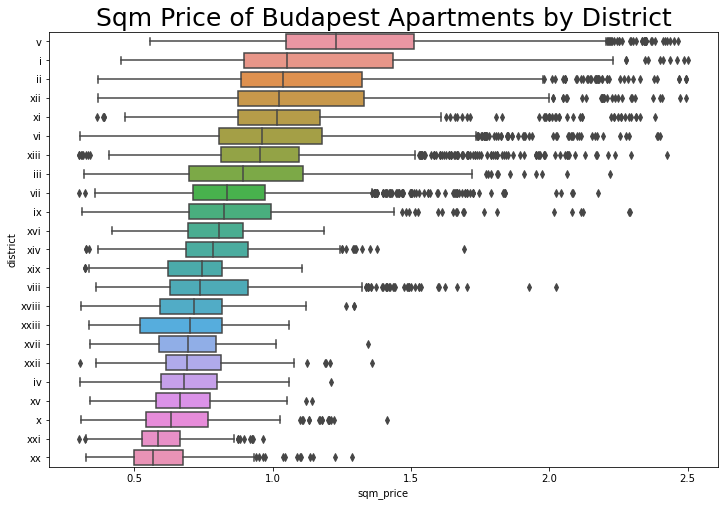

In [16]:
order_of_axis = all_apt_cleaned.groupby('district', dropna=False).agg(number_of_obs=('district', 'count'),
                                                                      mean_sqm_price = ('sqm_price', 'median')).reset_index()
order_of_axis = order_of_axis.sort_values(by='mean_sqm_price', ascending=False)['district']

plt.figure(figsize=(12, 8))
sns.boxplot(y=all_apt_cleaned["district"], x=all_apt_cleaned["sqm_price"],
            order= order_of_axis)
plt.title('Sqm Price of Budapest Apartments by District', size = 25)
plt.show()

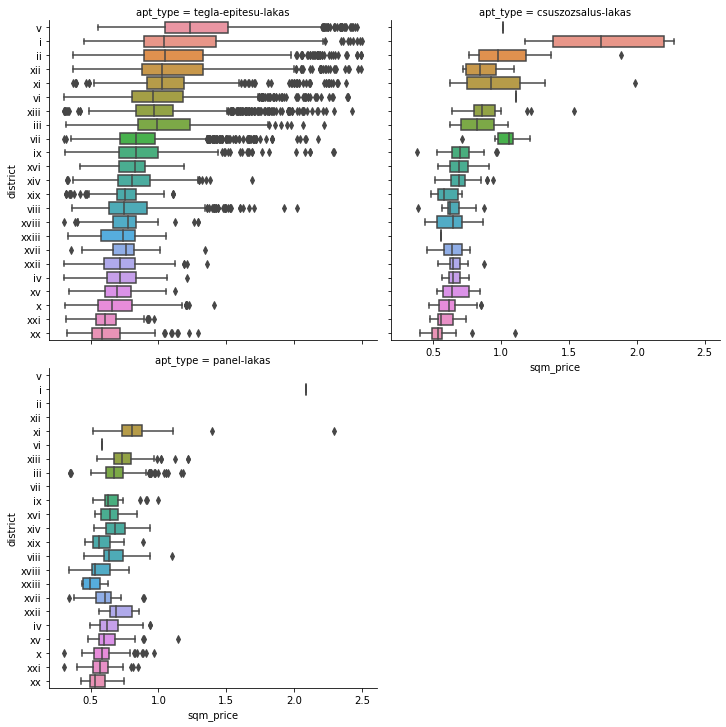

In [17]:
sns.catplot(
    data=all_apt_cleaned, x='sqm_price', y='district',
    col='apt_type', kind='box', col_wrap=2, order=order_of_axis
)
plt.show()

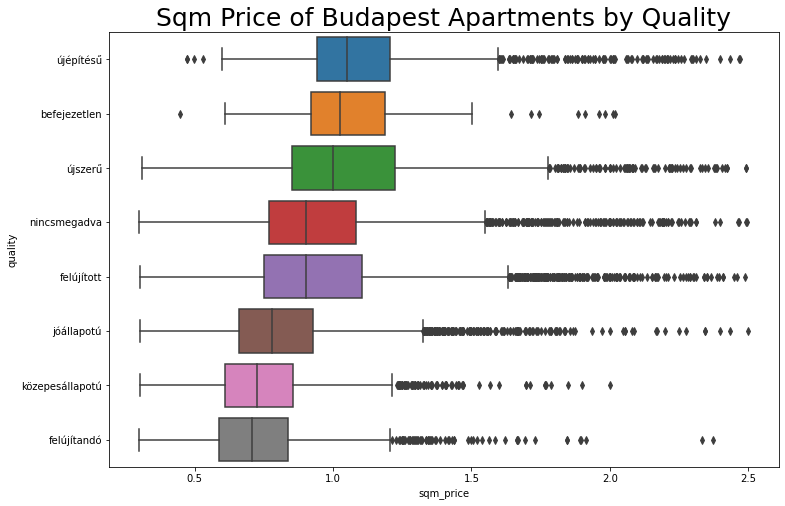

In [18]:
order_of_axis = all_apt_cleaned.groupby('quality', dropna=False).agg(number_of_obs=('quality', 'count'),
                                                                      mean_sqm_price = ('sqm_price', 'median')).reset_index()
order_of_axis = order_of_axis.sort_values(by='mean_sqm_price', ascending=False)['quality']

plt.figure(figsize=(12, 8))
sns.boxplot(y=all_apt_cleaned["quality"], x=all_apt_cleaned["sqm_price"],
            order= order_of_axis)
plt.title('Sqm Price of Budapest Apartments by Quality', size = 25)
plt.show()

## We want to have coordinates and postcodes for addresses too to be able to put our apartments to a map, and use the post code to get some additional information.

To do this I use the OSM API to convert addresses to lat and lng.

In [19]:
g = geocoder.osm("Abos utca 23, XII. kerület, Budapest, Hungary")
#g.json

In [20]:
print("lat:", g.json['lat'], " lon:", g.json['lng'], g.json['postal'])

lat: 47.499706  lon: 19.0115648 1126


In [21]:
def get_coordinates_for_addresses(data = all_apt_cleaned, address_column_name = 'adresses',
                                  limit = 50, save_csv = True):
    
    addresses_data = data.head(limit)
    addresses_data = addresses_data[[address_column_name]]
    addresses_data = addresses_data.drop_duplicates()
    addresses_data['extended_address'] = addresses_data[address_column_name] + ", Budapest, Hungary"
    
    address_list = []
    lat_list = []
    lng_list = []
    post_code_list = []

    for address in tqdm(addresses_data['extended_address'], desc = "Progress: "):
        try:
            g = geocoder.osm(address)
            lat_address = g.json['lat']
            lng_address = g.json['lng']
            post_code = g.json['postal']
        except:
            lat_address = float("nan")
            lng_address = float("nan")
            post_code = float("nan")

        lat_list.append(lat_address)
        lng_list.append(lng_address)
        post_code_list.append(post_code)
        address_list.append(address)
    
    addresses_data['lat'] = lat_list
    addresses_data['lat'] = addresses_data['lat'].astype(float)
    
    addresses_data['lng'] = lng_list
    addresses_data['lng'] = addresses_data['lng'].astype(float)
    
    addresses_data['postcode'] = post_code_list
    addresses_data['postcode'] = addresses_data['postcode'].apply(pd.to_numeric, errors='coerce')
    #addresses_data['postcode'] = addresses_data['postcode'].astype(float)
    addresses_data['last_postcode'] = pd.to_numeric(addresses_data['postcode'])
    addresses_data['last_postcode'] = addresses_data['last_postcode'].astype(int, errors='ignore')
    addresses_data['last_postcode'] = addresses_data['last_postcode'].astype(str).str.strip().str[-3]
    addresses_data['last_postcode'] = np.where(addresses_data['last_postcode'] == "n", str("nan"), addresses_data['last_postcode'])
    
    
    # Drop duplicates
    addresses_data = addresses_data.reset_index(drop = True)
    
    if save_csv:
        now = datetime.now()
        dt_string = now.strftime("%Y%m%d_%H%M%S")
        addresses_coordinates_data_filename = '../addresses_with_coordinates' + str(dt_string) + '.csv'
        addresses_data.to_csv(addresses_coordinates_data_filename, encoding='utf-8', index=False)
    
    return(addresses_data)

In [22]:
#addresses_dt = get_coordinates_for_addresses(limit=len(all_apt_cleaned))

In [23]:
addresses_dt = pd.read_csv('../addresses_with_coordinates20220111_170217.csv')

In [24]:
addresses_dt

,adresses,extended_address,lat,lng,postcode,last_postcode
0,"Abonyi utca 12. mfsz 1., XIV. kerület","Abonyi utca 12. mfsz 1., XIV. kerület, Budape...",NaN,NaN,NaN,NaN
1,"Abonyi utca 14, XIV. kerület","Abonyi utca 14, XIV. kerület, Budapest, Hungary",47.507331,19.089881,1146.0,6.0
2,"Abonyi utca 4., XIV. kerület","Abonyi utca 4., XIV. kerület, Budapest, Hungary",47.506101,19.087937,1146.0,6.0
3,"Abonyi utca, XIV. kerület","Abonyi utca, XIV. kerület, Budapest, Hungary",47.507331,19.089881,1146.0,6.0
4,"Abos utca 23, XII. kerület","Abos utca 23, XII. kerület, Budapest, Hungary",47.499706,19.011565,1126.0,6.0
...,...,...,...,...,...,...
4429,"Őrnagy utca 8, XIV. kerület","Őrnagy utca 8, XIV. kerület, Budapest, Hungary",47.501632,19.111092,1143.0,3.0
4430,"Őrnagy utca, XIV. kerület","Őrnagy utca, XIV. kerület, Budapest, Hungary",47.500737,19.111510,1143.0,3.0
4431,"Ősrepülő utca, XVII. kerület","Ősrepülő utca, XVII. kerület, Budapest, Hungary",47.470670,19.225553,1174.0,4.0
4432,"Ősz utca, XX. kerület","Ősz utca, XX. kerület, Budapest, Hungary",47.445107,19.101489,1203.0,3.0


In [25]:
## Merging back the coordinates files to the original file
all_apt_cleaned = pd.merge(all_apt_cleaned, addresses_dt, left_on= ['adresses'], right_on=['adresses'], how = 'left')

We can also define variables from some locations within the city.

In [26]:
def create_distances_from_local_points(data_original_coordinates = all_apt_cleaned):
    
    # initialize data
    data = [['korforgalom', 47.49784918136573, 19.040155552114864],
            ['westend', 47.511260986328125, 19.05663299560547],
            ['deakter', 47.4972514, 19.0540535],
            ['varosloget', 47.5148210624106,19.084308817687983],
            ['puskasstadion', 47.50202670121633,19.10539098054504],
            ['boraroster', 47.48010231024167,19.06715340882873],
            ['moricz', 47.47535130259566,19.040599539581294],
            ['mammut', 47.50916777699885,19.026051237884516]]
    
    # Create the pandas DataFrame
    important_locations = pd.DataFrame(data, columns = ['location', 'location_lat', 'location_lng'])
    
    data_for_calculation = data_original_coordinates[['lat', 'lng']]
    data_for_calculation = data_for_calculation.drop_duplicates().reset_index(drop = True)
    
    for i in range(len(important_locations)):
        one_loc_string = important_locations['location'][i]
        one_loc_lat = important_locations['location_lat'][i]
        one_loc_lng = important_locations['location_lng'][i]
        
        colname_to_create = str(one_loc_string) + '_distance'
        
        distance_list = []
        
        for one_calculation in range(len(data_for_calculation)):
            try:
                dist = mpu.haversine_distance((data_for_calculation['lat'][one_calculation], data_for_calculation['lng'][one_calculation]),
                                              (one_loc_lat, one_loc_lng))
                
                dist = round(dist, 1)
                dist = dist * 1000
                dist = int(dist)
            except:
                dist = float("nan")
            distance_list.append(dist)
                
        data_for_calculation[colname_to_create] = distance_list
    
    
    return(data_for_calculation)

In [27]:
distance_data = create_distances_from_local_points()
distance_data

,lat,lng,korforgalom_distance,westend_distance,deakter_distance,varosloget_distance,puskasstadion_distance,boraroster_distance,moricz_distance,mammut_distance
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,47.507331,19.089881,3900.0,2500.0,2900.0,900.0,1300.0,3500.0,5100.0,4800.0
2,47.506101,19.087937,3700.0,2400.0,2700.0,1000.0,1400.0,3300.0,4900.0,4700.0
3,47.499706,19.011565,2200.0,3600.0,3200.0,5700.0,7100.0,4700.0,3500.0,1500.0
4,47.536915,19.128269,7900.0,6100.0,7100.0,4100.0,4200.0,7800.0,9500.0,8300.0
...,...,...,...,...,...,...,...,...,...,...
3328,47.501632,19.111092,5300.0,4200.0,4300.0,2500.0,400.0,4100.0,6000.0,6400.0
3329,47.500737,19.111510,5400.0,4300.0,4300.0,2600.0,500.0,4000.0,6000.0,6500.0
3330,47.470670,19.225553,14300.0,13500.0,13200.0,11700.0,9700.0,12000.0,13900.0,15600.0
3331,47.445107,19.101489,7500.0,8100.0,6800.0,7900.0,6300.0,4700.0,5700.0,9100.0


In [28]:
all_apt_cleaned = pd.merge(all_apt_cleaned, distance_data, left_on= ['lat', 'lng'], right_on=['lat', 'lng'], how = 'left')

In [29]:
all_apt_cleaned

,adresses,price_huf,base_area,balcony_size,area_wiht_balcony_sqm,sqm_price,quality,year_build,floor,max_floor,elevator,indoor_height,heating,for_handicap,bathroom_and_toilet,facing,view,garden,top_floor,parking,parking_place_price,apt_type,energy_label,link,download_time,panelprogram,webpage_all,district,full_room_number,half_room_number,extended_address,lat,lng,postcode,last_postcode,korforgalom_distance,westend_distance,deakter_distance,varosloget_distance,puskasstadion_distance,boraroster_distance,moricz_distance,mammut_distance
0,", XIV. kerület",52.50,67.0,4.0,69.0,0.760870,felújított,1950előtt,2,3,nincs,3mnélmagasabb,gázcirko,nincsmegadva,különhelyiségben,délkelet,nincsmegadva,nincsmegadva,nincsmegadva,utcaközterület,nincsmegadva,tegla-epitesu-lakas,nincsmegadva,https://ingatlan.com/xiv-ker/elado+lakas/tegla...,2022.01.11 21:45:16,nincsmegadva,https://ingatlan.com/xiv-ker/elado+lakas/tegla...,xiv,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,", XVIII. kerület",34.00,73.0,9.0,77.5,0.438710,jóállapotú,1950és1980között,1,4,nincs,3mnélalacsonyabb,házközpontiegyediméréssel,nincsmegadva,különhelyiségben,délnyugat,nincsmegadva,nincsmegadva,nincsmegadva,utcaközterület,nincsmegadva,csuszozsalus-lakas,nincsmegadva,https://ingatlan.com/xviii-ker/elado+lakas/csu...,2022.01.13 00:23:07,nincsmegadva,https://ingatlan.com/xviii-ker/elado+lakas/csu...,xviii,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,", XXI. kerület",31.50,54.0,0.0,54.0,0.583333,felújított,1981és2000között,2,4,nincs,nincsmegadva,távfűtés,nem,különhelyiségben,nincsmegadva,utcai,nem,nemtetőtéri,utcaközterületingyenes,nincsmegadva,panel-lakas,nincsmegadva,https://ingatlan.com/xxi-ker/elado+lakas/panel...,2022.01.11 22:27:53,nincsmegadva,https://ingatlan.com/xxi-ker/elado+lakas/panel...,xxi,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"511. utca, XVII. kerület",69.90,75.0,28.0,89.0,0.785393,újszerű,2001és2010között,2,2,nincs,3mnélalacsonyabb,házközpontiegyediméréssel,nem,különésegybenis,délnyugat,panorámás,nem,legfelsőemeletnemtetőtéri,teremgarázshelymegvásárolható,3500000Ft,tegla-epitesu-lakas,3500000Ft,https://ingatlan.com/xvii-ker/elado+lakas/tegl...,2022.01.12 00:59:39,3500000Ft,https://ingatlan.com/xvii-ker/elado+lakas/tegl...,xvii,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Abonyi utca 12. mfsz 1., XIV. kerület",42.00,42.0,0.0,42.0,1.000000,felújított,1950előtt,félemelet,3,nincs,3mnélmagasabb,gázcirko,nincsmegadva,egyhelyiségben,északnyugat,kertrenéz,nincsmegadva,nincsmegadva,udvaribeállóbennevanazárban,nincsmegadva,tegla-epitesu-lakas,nincsmegadva,https://ingatlan.com/xiv-ker/elado+lakas/tegla...,2022.01.13 09:27:33,nincsmegadva,https://ingatlan.com/xiv-ker/elado+lakas/tegla...,xiv,1,1,"Abonyi utca 12. mfsz 1., XIV. kerület, Budape...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22139,"Őrnagy utca, XIV. kerület",55.00,80.0,0.0,80.0,0.687500,jóállapotú,1950előtt,1,4,nincs,nincsmegadva,gázkonvektor,nem,egyhelyiségben,nincsmegadva,nincsmegadva,nincsmegadva,nemtetőtéri,utcaközterületfizetősövezet,nincsmegadva,tegla-epitesu-lakas,nincsmegadva,https://ingatlan.com/xiv-ker/elado+lakas/tegla...,2022.01.12 19:41:38,nincsmegadva,https://ingatlan.com/xiv-ker/elado+lakas/tegla...,xiv,3,0,"Őrnagy utca, XIV. kerület, Budapest, Hungary",47.500737,19.111510,1143.0,3.0,5400.0,4300.0,4300.0,2600.0,500.0,4000.0,6000.0,6500.0
22140,"Ősrepülő utca, XVII. kerület",45.99,46.0,0.0,46.0,0.999783,újszerű,2001és2010között,1,2,nincsmegadva,3mnélalacsonyabb,gázcirko,nincsmegadva,nincsmegadva,délnyugat,nincsmegadva,nincsmegadva,nemtetőtéri,udvaribeálló,nincsmegadva,tegla-epitesu-lakas,nincsmegadva,https://ingatlan.com/xvii-ker/elado+lakas/tegl...,2022.01.13 01:41:59,nincsmegadva,https://ingatlan.com/xvii-ker/elado+lakas/tegl...,xvii,2,1,"Ősrepülő utca, XVII. kerület, 

## Postcode summary

In [30]:
count_district = all_apt_cleaned.groupby(['district', 'last_postcode'], dropna=False).agg(number_of_obs=('district', 'count'),
                                                                       mean_price = ('price_huf', 'mean'),
                                                                       median_price = ('price_huf', 'median'),
                                                                       mean_sqm = ('area_wiht_balcony_sqm', 'mean'),
                                                                       median_sqm = ('area_wiht_balcony_sqm', 'median'),
                                                                       mean_sqm_price = ('sqm_price', 'mean'),
                                                                       median_sqm_price = ('sqm_price', 'median'))

count_district['mean_price'] = count_district['mean_price'].round(2)
count_district['mean_sqm'] = count_district['mean_sqm'].round(2)
count_district['mean_sqm_price'] = count_district['mean_sqm_price'].round(4)
count_district = count_district.sort_values(by=['district', 'last_postcode'], ascending=True).reset_index()
count_district

,district,last_postcode,number_of_obs,mean_price,median_price,mean_sqm,median_sqm,mean_sqm_price,median_sqm_price
0,i,0.0,17,86.41,78.900,93.56,96.50,0.9295,0.856250
1,i,1.0,46,132.81,120.870,96.13,85.00,1.4035,1.368826
2,i,2.0,88,80.50,71.625,78.85,79.50,1.0247,0.963733
3,i,3.0,19,90.04,78.000,69.63,65.00,1.2619,0.998780
4,i,4.0,11,117.79,119.000,59.23,57.00,1.9564,2.081250
...,...,...,...,...,...,...,...,...,...
199,xxiii,4.0,1,61.50,61.500,79.50,79.50,0.7736,0.773585
200,xxiii,7.0,50,54.10,55.700,77.46,75.00,0.7039,0.739175
201,xxiii,8.0,9,25.93,24.800,54.22,55.00,0.5051,0.463636
202,xxiii,9.0,10,53.71,58.950,87.50,86.25,0.6229,0.593305


## Coordinates

In [31]:
# Add jitter to coordinates
sigma = 0.0003
    
all_apt_cleaned['lat_jitter'] = all_apt_cleaned['lat'].apply(lambda x: np.random.normal(x, sigma, 1)[0])
all_apt_cleaned['lng_jitter'] = all_apt_cleaned['lng'].apply(lambda x: np.random.normal(x, sigma, 1)[0])

# Create mercator coordinates
r_major = 6378137.000
all_apt_cleaned['x'] = r_major * np.radians(all_apt_cleaned['lng_jitter'])
scale = all_apt_cleaned['x'].median()/all_apt_cleaned['lng_jitter'].median()
all_apt_cleaned['y'] = 180.0/np.pi * np.log(np.tan(np.pi/4.0 + all_apt_cleaned['lat_jitter'] * (np.pi/180.0)/2.0)) * scale

In [32]:
# Select tile set to use
chosentile = get_provider(OSM)
# Choose palette
palette = Spectral6
# Tell Bokeh to use df as the source of the data
source = ColumnDataSource(data=all_apt_cleaned[all_apt_cleaned['x'].notna()])
# Define color mapper - which column will define the colour of the data points
color_mapper = linear_cmap(field_name = 'price_huf', palette = palette, low = all_apt_cleaned['price_huf'].min(), high = all_apt_cleaned['price_huf'].max())
# Set tooltips - these appear when we hover over a data point in our map, very nifty and very useful
tooltips = [("Price","@price_huf"), ("sqmPrice","@sqm_price"), ("Address","@adresses"), ("Link", "@webpage_all")]
# Create figure
p = figure(title = 'Budapest', x_axis_type="mercator", y_axis_type="mercator",
           x_axis_label = 'Longitude', y_axis_label = 'Latitude', tooltips = tooltips,
          plot_height=600, plot_width = 800)
# Add map tile
p.add_tile(chosentile)
# Add points using mercator coordinates
p.circle(x = 'x', y = 'y', color = color_mapper, source=source, size=10, fill_alpha = 0.3)
#Defines color bar
color_bar = ColorBar(color_mapper=color_mapper['transform'], 
                     formatter = NumeralTickFormatter(format='0.0[0000]'), 
                     label_standoff = 13, width=8, location=(0,0))
# Set color_bar location
p.add_layout(color_bar, 'right')
# Display in notebook
output_notebook()
# Show map
#show(p)

Loading BokehJS ...

In [33]:
# Select tile set to use
chosentile = get_provider(OSM)
# Choose palette
palette = Spectral6
# Tell Bokeh to use df as the source of the data
source = ColumnDataSource(data=all_apt_cleaned[all_apt_cleaned['x'].notna()])
# Define color mapper - which column will define the colour of the data points
color_mapper = linear_cmap(field_name = 'sqm_price', palette = palette, low = all_apt_cleaned['sqm_price'].min(), high = all_apt_cleaned['sqm_price'].max())
# Set tooltips - these appear when we hover over a data point in our map, very nifty and very useful
tooltips = [("Price","@price_huf"), ("sqmPrice","@sqm_price"), ("Address","@adresses"), ("Link", "@webpage_all")]
# Create figure
p = figure(title = 'Budapest', x_axis_type="mercator", y_axis_type="mercator",
           x_axis_label = 'Longitude', y_axis_label = 'Latitude', tooltips = tooltips,
          plot_height=600, plot_width = 800)
# Add map tile
p.add_tile(chosentile)
# Add points using mercator coordinates
p.circle(x = 'x', y = 'y', color = color_mapper, source=source, size=10, fill_alpha = 0.3)
#Defines color bar
color_bar = ColorBar(color_mapper=color_mapper['transform'], 
                     formatter = NumeralTickFormatter(format='0.0[0000]'), 
                     label_standoff = 13, width=8, location=(0,0))
# Set color_bar location
p.add_layout(color_bar, 'right')
# Display in notebook
output_notebook()
# Show map
#show(p)

Loading BokehJS ...

In [34]:
from bokeh.models import ColumnDataSource, OpenURL, TapTool
from bokeh.plotting import show, figure

p = figure(plot_width = 400, plot_height = 400,
   tools = "tap", title = "Click the Dots")

source1 = ColumnDataSource(data = dict(
   x = [1, 2, 3, ],
   y = [2, 5, 8, ],
   color = ["navy", "orange", "olive", ]
))
source2 = ColumnDataSource(data = dict(
   x = [4, 5, 6],
   y = [2, 7, 4],
   color = ["firebrick", "gold", "skyblue"]
))

p.circle('x', 'y', color = 'color', size = 20, source = source1)
p.circle('x', 'y', color = 'color', size = 30, source = source2)

url = "http://www.colors.commutercreative.com/@color/"
taptool = p.select(type = TapTool)
taptool.callback = OpenURL(url = url)

#show(p)

<AxesSubplot:xlabel='sqm_price', ylabel='Count'>

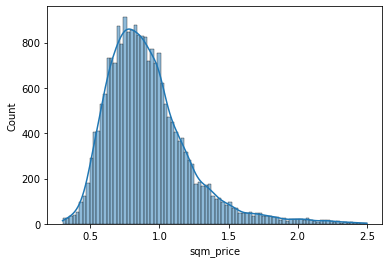

In [35]:
sns.histplot(all_apt_cleaned['sqm_price'], kde = True)

<AxesSubplot:xlabel='price_huf', ylabel='Count'>

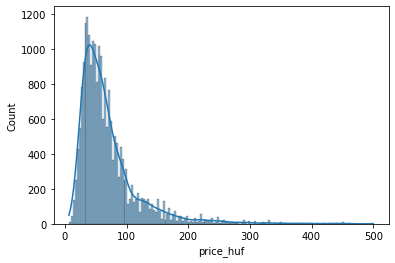

In [36]:
sns.histplot(all_apt_cleaned['price_huf'], kde = True)

<AxesSubplot:xlabel='base_area', ylabel='price_huf'>

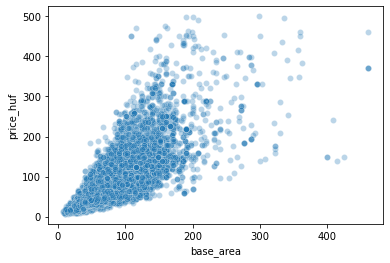

In [37]:
sns.scatterplot(data = all_apt_cleaned,
                x='base_area',
                y='price_huf',
                alpha = 0.3)

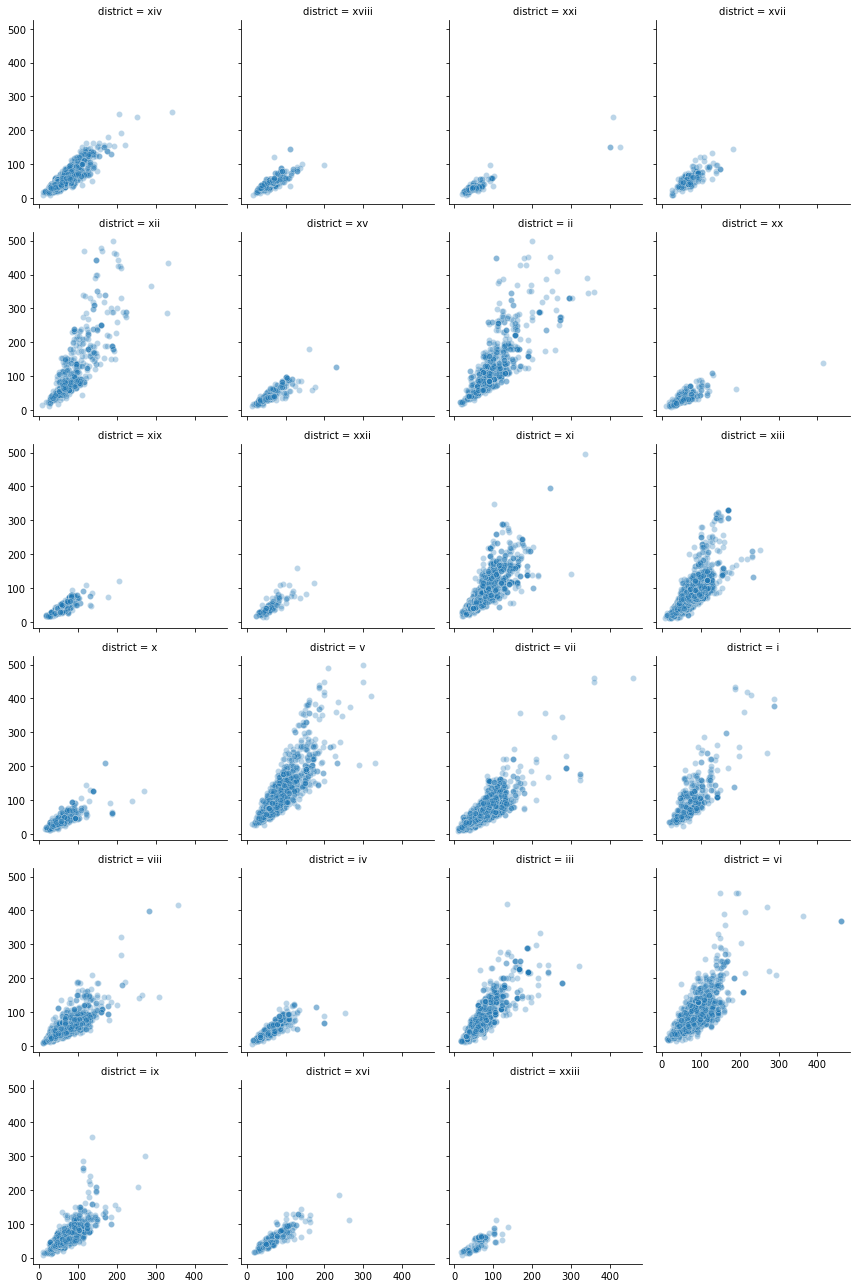

In [38]:
g = sns.FacetGrid(all_apt_cleaned, col="district", margin_titles=True, col_wrap=4)
g.map_dataframe(sns.scatterplot, x="base_area", y="price_huf", alpha = 0.3)

## The data contains similar apartments, this is how ingatlan.com tries to prevent scraping

(I already handled this in the data manipulation part, but if i would not here there would be very similar apartments)

In [39]:
madarasz_apts = all_apt_cleaned[all_apt_cleaned['adresses'].str.contains('Madarász', regex=True)]
madarasz_apts = madarasz_apts.sort_values('price_huf', ascending=False)
madarasz_apts

,adresses,price_huf,base_area,balcony_size,area_wiht_balcony_sqm,sqm_price,quality,year_build,floor,max_floor,elevator,indoor_height,heating,for_handicap,bathroom_and_toilet,facing,view,garden,top_floor,parking,parking_place_price,apt_type,energy_label,link,download_time,panelprogram,webpage_all,district,full_room_number,half_room_number,extended_address,lat,lng,postcode,last_postcode,korforgalom_distance,westend_distance,deakter_distance,varosloget_distance,puskasstadion_distance,boraroster_distance,moricz_distance,mammut_distance,lat_jitter,lng_jitter,x,y
13174,"Madarász Viktor utca, XIII. kerület",49.9,58.0,4.0,60.0,0.831667,felújított,nincsmegadva,6,10,van,3mnélalacsonyabb,házközpontiegyediméréssel,igen,különhelyiségben,nincsmegadva,nincsmegadva,nincsmegadva,nincsmegadva,utcaközterületfizetősövezet,nincsmegadva,panel-lakas,nincsmegadva,https://ingatlan.com/xiii-ker/elado+lakas/pane...,2022.01.12 18:53:16,nincsmegadva,https://ingatlan.com/xiii-ker/elado+lakas/pane...,xiii,1,2,"Madarász Viktor utca, XIII. kerület, Budapest...",47.552404,19.077491,1138.0,8.0,6700.0,4800.0,6400.0,4200.0,6000.0,8100.0,9000.0,6200.0,47.552307,19.077466,2.123694e+06,6.032695e+06
13173,"Madarász Viktor utca 39, XIII. kerület",34.5,35.0,0.0,35.0,0.985714,jóállapotú,nincsmegadva,9,10,van,3mnélalacsonyabb,távfűtés,nem,egyhelyiségben,nincsmegadva,panorámás,nem,nemtetőtéri,utcaközterület,nincsmegadva,panel-lakas,nincsmegadva,https://ingatlan.com/xiii-ker/elado+lakas/pane...,2022.01.13 01:24:27,nincsmegadva,https://ingatlan.com/xiii-ker/elado+lakas/pane...,xiii,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Modeling part

## Fix variables that we want to use for modeling

In [40]:
cols_we_want_to_keep = ['price_huf', 'sqm_price', 'base_area', 'balcony_size', 'area_wiht_balcony_sqm', 'full_room_number',
                        'half_room_number', 'district', 'lat', 'lng', 'apt_type', 'quality', 'year_build',
                        'floor', 'max_floor', 'top_floor','bathroom_and_toilet', 'indoor_height', 'view', 'facing',
                        #'heating',
                        'garden', 'elevator', 'for_handicap',
                        'last_postcode',
                        #'parking',
                         'korforgalom_distance',
                        #'westend_distance', 'deakter_distance', 'varosloget_distance',
                        #'puskasstadion_distance', 'boraroster_distance', 'moricz_distance', 'mammut_distance'
                       ]

modeling_data_base = all_apt_cleaned[cols_we_want_to_keep]
modeling_data_base

,price_huf,sqm_price,base_area,balcony_size,area_wiht_balcony_sqm,full_room_number,half_room_number,district,lat,lng,apt_type,quality,year_build,floor,max_floor,top_floor,bathroom_and_toilet,indoor_height,view,facing,garden,elevator,for_handicap,last_postcode,korforgalom_distance
0,52.50,0.760870,67.0,4.0,69.0,2,0,xiv,NaN,NaN,tegla-epitesu-lakas,felújított,1950előtt,2,3,nincsmegadva,különhelyiségben,3mnélmagasabb,nincsmegadva,délkelet,nincsmegadva,nincs,nincsmegadva,NaN,NaN
1,34.00,0.438710,73.0,9.0,77.5,3,0,xviii,NaN,NaN,csuszozsalus-lakas,jóállapotú,1950és1980között,1,4,nincsmegadva,különhelyiségben,3mnélalacsonyabb,nincsmegadva,délnyugat,nincsmegadva,nincs,nincsmegadva,NaN,NaN
2,31.50,0.583333,54.0,0.0,54.0,1,2,xxi,NaN,NaN,panel-lakas,felújított,1981és2000között,2,4,nemtetőtéri,különhelyiségben,nincsmegadva,utcai,nincsmegadva,nem,nincs,nem,NaN,NaN
3,69.90,0.785393,75.0,28.0,89.0,3,0,xvii,NaN,NaN,tegla-epitesu-lakas,újszerű,2001és2010között,2,2,legfelsőemeletnemtetőtéri,különésegybenis,3mnélalacsonyabb,panorámás,délnyugat,nem,nincs,nem,NaN,NaN
4,42.00,1.000000,42.0,0.0,42.0,1,1,xiv,NaN,NaN,tegla-epitesu-lakas,felújított,1950előtt,félemelet,3,nincsmegadva,egyhelyiségben,3mnélmagasabb,kertrenéz,északnyugat,nincsmegadva,nincs,nincsmegadva,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22139,55.00,0.687500,80.0,0.0,80.0,3,0,xiv,47.500737,19.111510,tegla-epitesu-lakas,jóállapotú,1950előtt,1,4,nemtetőtéri,egyhelyiségben,nincsmegadva,nincsmegadva,nincsmegadva,nincsmegadva,nincs,nem,3.0,5400.0
22140,45.99,0.999783,46.0,0.0,46.0,2,1,xvii,47.470670,19.225553,tegla-epitesu-lakas,újszerű,2001és2010között,1,2,nemtetőtéri,nincsmegadva,3mnélalacsonyabb,nincsmegadva,délnyugat,nincsmegadva,nincsmegadva,nincsmegadva,4.0,14300.0
22141,19.90,0.537838,37.0,0.0,37.0,1,0,xx,47.445107,19.101489,tegla-epitesu-lakas,jóállapotú,nincsmegadva,nincsmegadva,földszintes,nincsmegadva,egyhelyiségben,nincsmegadva,udvari,nincsmegadva,nincsmegadva,nincsmegadva,nincsmegadva,3.0,7500.0
22142,19.90,0.423404,37.0,20.0,47.0,1,0,xx,47.445107,19.101489,tegla-epitesu-lakas,felújított,nincsmegadva,földszint,földszintes,nemtetőtéri,egyhelyiségben,3mnélalacsonyabb,kertrenéz,nincsmegadva,igen,nincs,igen,3.0,7500.0


### Fix some variables which can be used as input variables in our model

In [41]:
def fixing_variables_for_modeling(data = modeling_data_base):
    
    warnings.filterwarnings('ignore')
    
    print(len(data))
    
    #drop lat lng with nan values
    cleand_data  = data.dropna(subset=['lat', 'lng'])
    print(len(cleand_data))

    #drop postcode nan values
    cleand_data  = data.dropna(subset=['last_postcode'])
    print(len(cleand_data))
    
    #fix year built
    cleand_data['year_build'] = cleand_data['year_build'].replace(['2001és2010között'],'2001')
    cleand_data['year_build'] = cleand_data['year_build'].replace(['1950előtt'],'1900')
    cleand_data['year_build'] = cleand_data['year_build'].replace(['nincsmegadva'],'0')
    cleand_data['year_build'] = cleand_data['year_build'].replace(['1950és1980között'],'1950')
    cleand_data['year_build'] = cleand_data['year_build'].replace(['1981és2000között'],'1981')
    cleand_data['year_build'] = cleand_data['year_build'].astype(int)
    
    # floor
    cleand_data['floor'] = cleand_data['floor'].replace(['10felett'],'11')
    cleand_data['floor'] = cleand_data['floor'].replace(['nincsmegadva'],'-100')
    cleand_data['floor'] = cleand_data['floor'].replace(['félemelet'],'0.5')
    cleand_data['floor'] = cleand_data['floor'].replace(['földszint'],'0')
    cleand_data['floor'] = cleand_data['floor'].replace(['szuterén'],'-1')
    cleand_data['floor'] = cleand_data['floor'].astype(float)
    
    # max floor
    cleand_data['max_floor'] = cleand_data['max_floor'].replace(['többmint10'],'11')
    cleand_data['max_floor'] = cleand_data['max_floor'].replace(['nincsmegadva'],'-1')
    cleand_data['max_floor'] = cleand_data['max_floor'].replace(['földszintes'],'0')
    cleand_data['max_floor'] = cleand_data['max_floor'].astype(float)
    
    
    # top floor
    cleand_data['top_floor'] = cleand_data['top_floor'].replace(['beépített'],'nincsmegadva')
    
    # indoor height
    cleand_data['indoor_height'] = cleand_data['indoor_height'].replace(['3mnélalacsonyabb'],'3-')
    cleand_data['indoor_height'] = cleand_data['indoor_height'].replace(['3mnélmagasabb'],'3+')
    
    # parking
    cleand_data['indoor_height'] = cleand_data['indoor_height'].replace(['3mnélmagasabb'],'3+', regex = True)
    
    return(cleand_data)

In [42]:
modeling_data = fixing_variables_for_modeling()

22144
17850
17468


Ended up with this many observations after cleaning

In [43]:
modeling_data

,price_huf,sqm_price,base_area,balcony_size,area_wiht_balcony_sqm,full_room_number,half_room_number,district,lat,lng,apt_type,quality,year_build,floor,max_floor,top_floor,bathroom_and_toilet,indoor_height,view,facing,garden,elevator,for_handicap,last_postcode,korforgalom_distance
5,34.99,0.624821,56.0,0.0,56.0,2,0,xiv,47.507331,19.089881,tegla-epitesu-lakas,jóállapotú,1900,-1.0,2.0,nemtetőtéri,különésegybenis,3-,kertrenéz,délkelet,nincsmegadva,nincs,nem,6.0,3900.0
6,49.90,0.804839,62.0,0.0,62.0,2,0,xiv,47.506101,19.087937,tegla-epitesu-lakas,felújítandó,1900,2.0,3.0,nincsmegadva,egyhelyiségben,3+,udvari,délkelet,nem,nincsmegadva,nincsmegadva,6.0,3700.0
7,14.90,0.677273,22.0,0.0,22.0,1,0,xiv,47.507331,19.089881,tegla-epitesu-lakas,felújított,0,-100.0,0.0,nincsmegadva,nincsmegadva,nincsmegadva,udvari,nincsmegadva,nincsmegadva,nincsmegadva,nincsmegadva,6.0,3900.0
8,30.90,0.735714,42.0,0.0,42.0,1,0,xiv,47.507331,19.089881,tegla-epitesu-lakas,felújítandó,1900,1.0,6.0,nincsmegadva,egyhelyiségben,3+,utcai,északnyugat,nincsmegadva,van,nem,6.0,3900.0
9,34.99,0.624821,56.0,0.0,56.0,2,0,xiv,47.507331,19.089881,tegla-epitesu-lakas,felújított,0,-1.0,-1.0,nincsmegadva,egyhelyiségben,nincsmegadva,udvari,nincsmegadva,nincsmegadva,nincsmegadva,nincsmegadva,6.0,3900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22139,55.00,0.687500,80.0,0.0,80.0,3,0,xiv,47.500737,19.111510,tegla-epitesu-lakas,jóállapotú,1900,1.0,4.0,nemtetőtéri,egyhelyiségben,nincsmegadva,nincsmegadva,nincsmegadva,nincsmegadva,nincs,nem,3.0,5400.0
22140,45.99,0.999783,46.0,0.0,46.0,2,1,xvii,47.470670,19.225553,tegla-epitesu-lakas,újszerű,2001,1.0,2.0,nemtetőtéri,nincsmegadva,3-,nincsmegadva,délnyugat,nincsmegadva,nincsmegadva,nincsmegadva,4.0,14300.0
22141,19.90,0.537838,37.0,0.0,37.0,1,0,xx,47.445107,19.101489,tegla-epitesu-lakas,jóállapotú,0,-100.0,0.0,nincsmegadva,egyhelyiségben,nincsmegadva,udvari,nincsmegadva,nincsmegadva,nincsmegadva,nincsmegadva,3.0,7500.0
22142,19.90,0.423404,37.0,20.0,47.0,1,0,xx,47.445107,19.101489,tegla-epitesu-lakas,felújított,0,0.0,0.0,nemtetőtéri,egyhelyiségben,3-,kertrenéz,nincsmegadva,igen,nincs,igen,3.0,7500.0


In [44]:
modeling_data.describe()

,price_huf,sqm_price,base_area,balcony_size,area_wiht_balcony_sqm,full_room_number,half_room_number,lat,lng,year_build,floor,max_floor,last_postcode,korforgalom_distance
count,17468.000000,17468.000000,17468.000000,17468.000000,17468.00000,17468.000000,17468.000000,17468.000000,17468.000000,17468.000000,17468.000000,17468.000000,17468.000000,17468.000000
mean,69.238004,0.916947,70.542993,6.671914,73.87895,2.363236,0.272212,47.503518,19.074293,1529.611862,-4.919539,3.339020,4.496737,5020.992672
std,50.342625,0.301106,35.476000,20.098186,39.28981,1.163466,0.580825,0.037656,0.043576,808.350185,26.271493,3.341383,2.436376,3166.214632
min,6.500000,0.300000,8.000000,0.000000,8.00000,0.000000,0.000000,47.378951,18.937419,0.000000,-100.000000,-1.000000,0.000000,100.000000
25%,38.500000,0.711111,47.000000,0.000000,49.00000,2.000000,0.000000,47.484079,19.049536,1900.000000,0.500000,-1.000000,2.000000,2500.000000
50%,55.655000,0.871429,64.000000,0.000000,66.00000,2.000000,0.000000,47.503873,19.069409,1900.000000,2.000000,3.000000,4.000000,4200.000000
75%,81.000000,1.053846,85.000000,6.000000,89.00000,3.000000,0.000000,47.523824,19.094379,2001.000000,3.000000,5.000000,7.000000,6900.000000
max,500.000000,2.500000,460.000000,563.000000,471.50000,20.000000,11.000000,47.606607,19.314670,2025.000000,11.000000,11.000000,9.000000,21100.000000


In [45]:
modeling_data.describe(include=["object"])

,district,apt_type,quality,top_floor,bathroom_and_toilet,indoor_height,view,facing,garden,elevator,for_handicap
count,17468,17468,17468,17468,17468,17468,17468,17468,17468,17468,17468
unique,23,3,8,6,4,3,5,9,3,3,3
top,xiii,tegla-epitesu-lakas,felújított,nemtetőtéri,nincsmegadva,3-,utcai,nincsmegadva,nincsmegadva,van,nincsmegadva
freq,2301,15844,4468,9207,5582,6341,6238,6252,10650,9400,11217


In [46]:
categorical_vars = modeling_data.describe(include=["object"]).columns
continuous_vars = modeling_data.describe().columns

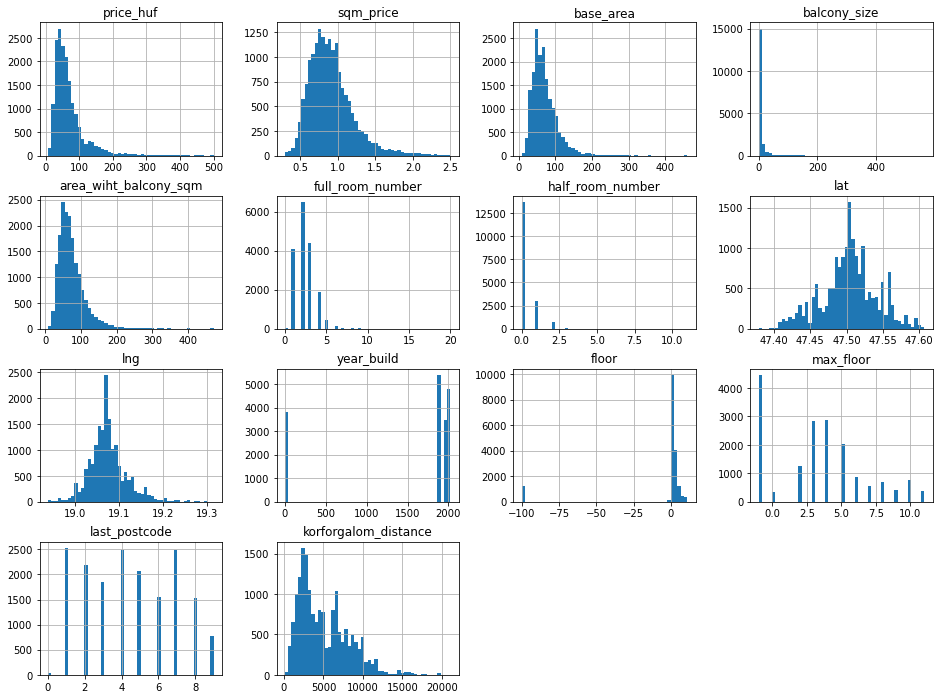

In [47]:
plot = modeling_data.hist(column=continuous_vars, figsize = (16, 12), bins = 50)

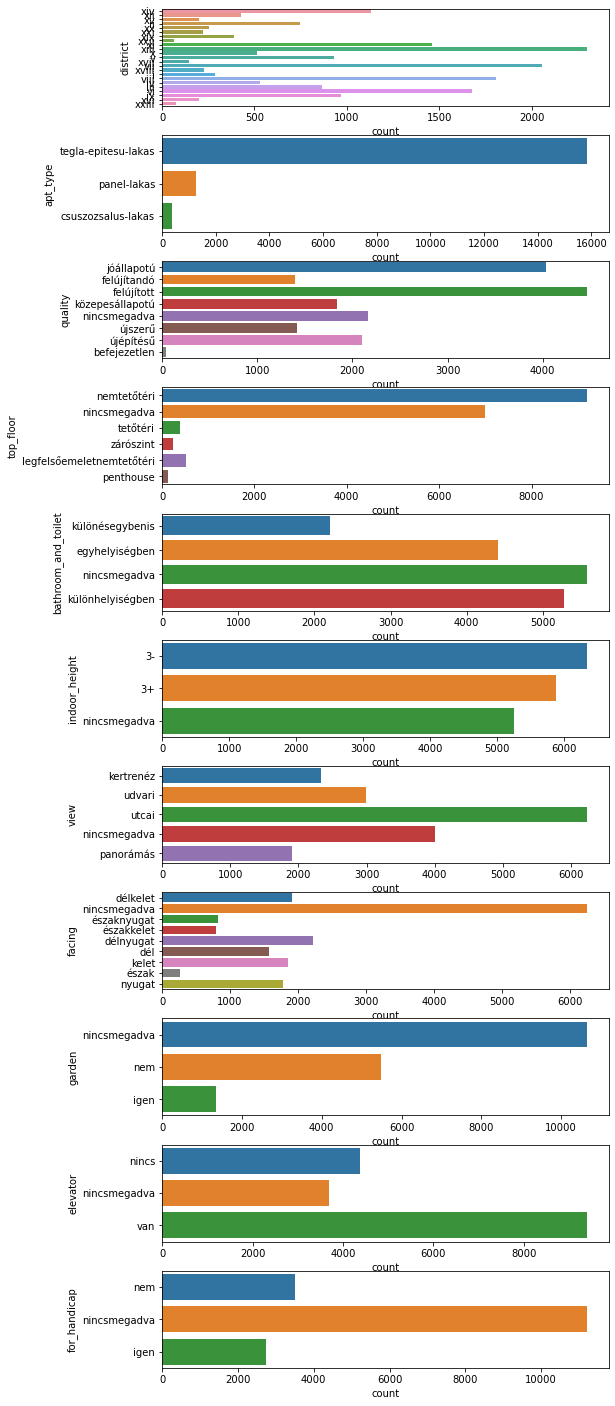

In [48]:
fig, axes = plt.subplots(11, 1, figsize=(8, 25))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1, hspace=0.3)

for i, ax in enumerate(axes.ravel()):
    plot = sns.countplot(y = categorical_vars[i], data=modeling_data, ax=ax)

## Train and Test split

In [49]:
from sklearn.model_selection import train_test_split

In [50]:
model_data_dummies = pd.get_dummies(modeling_data, columns = categorical_vars, drop_first=False)
model_data_dummies.columns

Index(['price_huf', 'sqm_price', 'base_area', 'balcony_size',
       'area_wiht_balcony_sqm', 'full_room_number', 'half_room_number', 'lat',
       'lng', 'year_build', 'floor', 'max_floor', 'last_postcode',
       'korforgalom_distance', 'district_i', 'district_ii', 'district_iii',
       'district_iv', 'district_ix', 'district_v', 'district_vi',
       'district_vii', 'district_viii', 'district_x', 'district_xi',
       'district_xii', 'district_xiii', 'district_xiv', 'district_xix',
       'district_xv', 'district_xvi', 'district_xvii', 'district_xviii',
       'district_xx', 'district_xxi', 'district_xxii', 'district_xxiii',
       'apt_type_csuszozsalus-lakas', 'apt_type_panel-lakas',
       'apt_type_tegla-epitesu-lakas', 'quality_befejezetlen',
       'quality_felújítandó', 'quality_felújított', 'quality_jóállapotú',
       'quality_közepesállapotú', 'quality_nincsmegadva', 'quality_újszerű',
       'quality_újépítésű', 'top_floor_legfelsőemeletnemtetőtéri',
       'top_floor_ne

In [51]:
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(model_data_dummies.drop(['price_huf', 'sqm_price'], axis=1),
                                                    model_data_dummies['sqm_price'],
                                                    test_size=0.2,
                                                    random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(13974, 82) (3494, 82) (13974,) (3494,)


In [52]:
X_train

,base_area,balcony_size,area_wiht_balcony_sqm,full_room_number,half_room_number,lat,lng,year_build,floor,max_floor,last_postcode,korforgalom_distance,district_i,district_ii,district_iii,district_iv,district_ix,district_v,district_vi,district_vii,district_viii,district_x,district_xi,district_xii,district_xiii,district_xiv,district_xix,district_xv,district_xvi,district_xvii,district_xviii,district_xx,district_xxi,district_xxii,district_xxiii,apt_type_csuszozsalus-lakas,apt_type_panel-lakas,apt_type_tegla-epitesu-lakas,quality_befejezetlen,quality_felújítandó,quality_felújított,quality_jóállapotú,quality_közepesállapotú,quality_nincsmegadva,quality_újszerű,quality_újépítésű,top_floor_legfelsőemeletnemtetőtéri,top_floor_nemtetőtéri,top_floor_nincsmegadva,top_floor_penthouse,top_floor_tetőtéri,top_floor_zárószint,bathroom_and_toilet_egyhelyiségben,bathroom_and_toilet_különhelyiségben,bathroom_and_toilet_különésegybenis,bathroom_and_toilet_nincsmegadva,indoor_height_3+,indoor_height_3-,indoor_height_nincsmegadva,view_kertrenéz,view_nincsmegadva,view_panorámás,view_udvari,view_utcai,facing_dél,facing_délkelet,facing_délnyugat,facing_kelet,facing_nincsmegadva,facing_nyugat,facing_észak,facing_északkelet,facing_északnyugat,garden_igen,garden_nem,garden_nincsmegadva,elevator_nincs,elevator_nincsmegadva,elevator_van,for_handicap_igen,for_handicap_nem,for_handicap_nincsmegadva
14877,47.0,0.0,47.0,1,0,47.502547,19.050616,1900,0.0,3.0,1.0,900.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0
15401,68.0,0.0,68.0,1,0,47.494738,19.053557,0,4.0,4.0,2.0,1100.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1
2809,76.0,4.0,78.0,3,0,47.517351,19.120207,2001,2.0,4.0,9.0,6400.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0
13307,38.0,0.0,38.0,1,0,47.491521,19.086105,1900,3.0,3.0,6.0,3500.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1
10383,34.0,9.0,38.5,1,1,47.450922,19.037805,2017,1.0,10.0,6.0,5200.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14675,60.0,0.0,60.0,3,0,47.491109,19.073641,1900,2.0,3.0,4.0,2600.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1
15529,157.0,7.0,160.5,5,0,47.515445,19.049536,1900,3.0,6.0,7.0,2100.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1
6653,117.0,4.0,119.0,4,0,47.532679,19.066777,1900,1.0,-1.0,8.0,4400.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1
1261,100.0,17.0,108.5,4,0,47.522382,19.063927,2019,2.0,-1.0,4.0,3300.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1


## Train a RF model

In [53]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

Here I just kept the final hyperparameters, because training otherwise takes long.

In [54]:
# Create the parameter grid based on the results of random search 
param_grid = {
    #'bootstrap': [True, False],
    'max_depth': [40],
    'max_features': [80],
    'min_samples_leaf': [15],
    'min_samples_split': [15],
    'n_estimators': [500]
}

# Instantiate the grid search model
rf_cv = GridSearchCV(estimator = RandomForestRegressor(),
                     param_grid = param_grid,
                     cv = 5,
                     n_jobs = -1,
                     verbose = 10,
                     scoring = 'neg_mean_absolute_percentage_error')

In [55]:
# Fit the grid search to the data
rf_model = rf_cv.fit(X_train, y_train)
# save the model to disk
pickle.dump(rf_model, open('rf_model.sav', 'wb'))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [56]:
# load the model from disk
rf_model = pickle.load(open('rf_model.sav', 'rb'))

In [57]:
print(rf_model.best_params_)

{'max_depth': 40, 'max_features': 80, 'min_samples_leaf': 15, 'min_samples_split': 15, 'n_estimators': 500}


In [58]:
rf_final = rf_model.best_estimator_
rf_final

RandomForestRegressor(max_depth=40, max_features=80, min_samples_leaf=15,
                      min_samples_split=15, n_estimators=500)

In [59]:
#rf_final_cv = model_selection.cross_val_score(rf_model,
#                                              X_train, y_train,
#                                              cv=5,
#                                              scoring='neg_root_mean_squared_error')
#
#print(rf_final_cv)
#print('------------------------------------')
#print("Mean RMSE using the RF model on the train data (with 5 CV): ", rf_final_cv.mean().round(3))

In [60]:
rf_final_train_pred = rf_final.predict(X_train)
rf_final_test_pred = rf_final.predict(X_test)

In [61]:
rf_final_test_pred

array([0.69116544, 1.11312394, 1.02417819, ..., 0.7700267 , 0.73647594,
       0.95778014])

In [62]:
X_test['test_pred_rf'] = rf_final_test_pred
X_test['y'] = y_test

In [63]:
X_test

,base_area,balcony_size,area_wiht_balcony_sqm,full_room_number,half_room_number,lat,lng,year_build,floor,max_floor,last_postcode,korforgalom_distance,district_i,district_ii,district_iii,district_iv,district_ix,district_v,district_vi,district_vii,district_viii,district_x,district_xi,district_xii,district_xiii,district_xiv,district_xix,district_xv,district_xvi,district_xvii,district_xviii,district_xx,district_xxi,district_xxii,district_xxiii,apt_type_csuszozsalus-lakas,apt_type_panel-lakas,apt_type_tegla-epitesu-lakas,quality_befejezetlen,quality_felújítandó,quality_felújított,quality_jóállapotú,quality_közepesállapotú,quality_nincsmegadva,quality_újszerű,quality_újépítésű,top_floor_legfelsőemeletnemtetőtéri,top_floor_nemtetőtéri,top_floor_nincsmegadva,top_floor_penthouse,top_floor_tetőtéri,top_floor_zárószint,bathroom_and_toilet_egyhelyiségben,bathroom_and_toilet_különhelyiségben,bathroom_and_toilet_különésegybenis,bathroom_and_toilet_nincsmegadva,indoor_height_3+,indoor_height_3-,indoor_height_nincsmegadva,view_kertrenéz,view_nincsmegadva,view_panorámás,view_udvari,view_utcai,facing_dél,facing_délkelet,facing_délnyugat,facing_kelet,facing_nincsmegadva,facing_nyugat,facing_észak,facing_északkelet,facing_északnyugat,garden_igen,garden_nem,garden_nincsmegadva,elevator_nincs,elevator_nincsmegadva,elevator_van,for_handicap_igen,for_handicap_nem,for_handicap_nincsmegadva,test_pred_rf,y
13685,61.0,0.0,61.0,2,1,47.478005,19.084255,1900,0.0,3.0,4.0,4000.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0.691165,0.539344
2994,80.0,0.0,80.0,3,1,47.560212,19.032834,2021,1.0,2.0,7.0,7000.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,1.113124,1.325000
17808,212.0,5.0,214.5,10,0,47.490942,19.065904,0,2.0,4.0,8.0,2100.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,1.024178,1.491375
9208,46.0,9.0,50.5,2,0,47.529393,19.069825,2023,2.0,6.0,4.0,4200.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,1.099136,1.114851
9387,120.0,0.0,120.0,4,0,47.490657,19.059332,1900,0.5,5.0,3.0,1600.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1.318030,1.375000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2055,46.0,0.0,46.0,2,0,47.493503,19.082100,1900,1.0,2.0,6.0,3200.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0.627615,0.641304
16652,37.0,0.0,37.0,2,0,47.501544,19.056761,0,1.0,-1.0,1.0,1300.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1.043008,1.189189
12075,37.0,0.0,37.0,1,0,47.482808,19.129740,1900,0.0,-1.0,2.0,6900.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0.770027,0.810811
17694,61.0,0.0,61.0,3,0,47.522852,19.083261,1900,-1.0,-1.0,5.0,4300.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0.736476,0.572131


In [64]:
def calculate_eval_metrics(data = X_test, y_true = 'y', model = rf_final, drop_columns = ['y', 'test_pred_rf']):
    
    try:
        y_true = data[y_true]
    except:
        next

    for c in drop_columns:
        try:
            data = data.drop([c], axis=1)
        except:
            next
    
    predictions = model.predict(data)

    RMSE = (((y_true - predictions) ** 2).mean() ** .5)
    RMSE = round(RMSE, 4)
    print("RMSE:", RMSE)
    
    MAE = abs(y_true - predictions).mean()
    MAE = round(MAE, 4)
    print("MAE:", MAE)

    MAPE = abs(1 - y_true/predictions).mean()
    MAPE = round(MAPE, 4)
    print("MAPE:", MAPE)
    
    return(RMSE, MAE, MAPE)

On the test set:

In [65]:
RMSE_rf, MAE_rf, MAPE_rf = calculate_eval_metrics()

RMSE: 0.1877
MAE: 0.1241
MAPE: 0.1319


On the train set:

In [66]:
RMSE_rf, MAE_rf, MAPE_rf = calculate_eval_metrics(data = X_train, y_true = y_train, model = rf_final, drop_columns = ['y', 'test_pred_rf', 'train_pred_rf'])

RMSE: 0.1588
MAE: 0.1048
MAPE: 0.1118


In [67]:
def plot_RMSE_scatter(data = X_test, y_true = 'y', y_pred = 'test_pred_rf'):
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(data[y_true],data[y_pred])
    RMSE_plot = sns.regplot(data = data, x=y_true, y=y_pred, fit_reg=True,
                            scatter_kws={'alpha':0.01,},
                            line_kws = {'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})

    plt.plot(np.arange (0, max(data[y_true]), 1/max(data[y_true])), np.arange (0, max(data[y_true]), 1/max(data[y_true])), color = 'red')


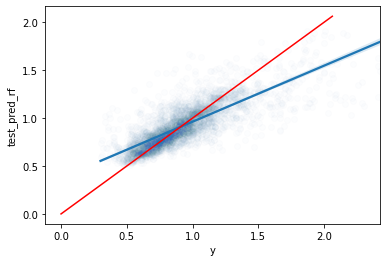

In [68]:
plot_RMSE_scatter()

In [69]:
def plot_RMSE_hist(data = X_test, y_true = 'y', y_pred = 'test_pred_rf'):
    
    RMSE_error_hist_plot = sns.histplot(data[y_pred] - data[y_true], kde = True)
    
    return(RMSE_error_hist_plot)

<AxesSubplot:ylabel='Count'>

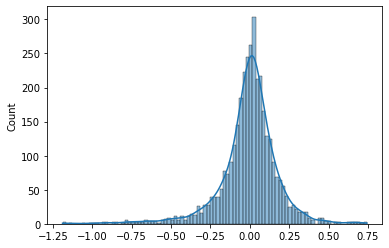

In [70]:
plot_RMSE_hist()

## xgBoost model

In [72]:
try:
    X_test = X_test.drop(['test_pred_rf'], axis=1)
except:
    print("no test rf was dropped")

try:
    X_test = X_test.drop(['test_pred_xgb'], axis=1)
except:
    print('no test xgb was dropped')

try:
    X_test = X_test.drop(['y'], axis=1)
except:
    print('no test y was dropped')

try:
    X_train = X_train.drop(['train_pred_rf'], axis=1)
except:
    print("no train rf was dropped")

try:
    X_train = X_train.drop(['train_pred_xgb'], axis=1)
except:
    print('no train xgb was dropped')

try:
    X_train = X_train.drop(['y'], axis=1)
except:
    print('no train y was dropped')

no test xgb was dropped
no train rf was dropped
no train xgb was dropped
no train y was dropped


In [73]:
len(X_train.columns)

82

In [74]:
xgb_grid = {'nthread':[-1], #when use hyperthread, xgboost may become slower
              'objective':['reg:squarederror'],
              'learning_rate': [0.05], #so called `eta` value
              'max_depth': [7],
              'min_child_weight': [10],
              'subsample': [0.95],
              'colsample_bytree': [0.95],
              'n_estimators': [500]}


xgb_cv = GridSearchCV(estimator = xgb.XGBRegressor(),
                      param_grid = xgb_grid,
                      n_jobs=-1,
                      cv=5,
                      verbose = 10,
                      scoring = 'neg_mean_absolute_percentage_error')

In [75]:
# train the model
xgb_model = xgb_cv.fit(X_train, y_train)
# save the model to disk
pickle.dump(xgb_model, open('xgboost_model.sav', 'wb'))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [76]:
# load the model from disk
xgb_model = pickle.load(open('xgboost_model.sav', 'rb'))

In [77]:
print(xgb_model.best_params_)

{'colsample_bytree': 0.95, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 10, 'n_estimators': 500, 'nthread': -1, 'objective': 'reg:squarederror', 'subsample': 0.95}


In [78]:
xgb_final = xgb_model.best_estimator_
xgb_final

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.95,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=7, min_child_weight=10, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=4, nthread=-1,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.95,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [79]:
#xgb_final_cv = model_selection.cross_val_score(xgb_cv,
#                                              X_train, y_train,
#                                              cv=5,
#                                              scoring='neg_root_mean_squared_error')
#
#print(xgb_final_cv)
#print('------------------------------------')
#print("Mean RMSE using the RF model on the train data (with 5 CV): ", rf_final_cv.mean().round(3))

In [80]:
xgb_final_train_pred = xgb_final.predict(X_train)
xgb_final_test_pred = xgb_final.predict(X_test)

In [81]:
xgb_final_test_pred

array([0.6553851 , 1.0604335 , 1.0890936 , ..., 0.75076544, 0.5386028 ,
       1.047928  ], dtype=float32)

In [82]:
X_test['test_pred_xgb'] = xgb_final_test_pred
X_test['y'] = y_test

In [83]:
X_test

,base_area,balcony_size,area_wiht_balcony_sqm,full_room_number,half_room_number,lat,lng,year_build,floor,max_floor,last_postcode,korforgalom_distance,district_i,district_ii,district_iii,district_iv,district_ix,district_v,district_vi,district_vii,district_viii,district_x,district_xi,district_xii,district_xiii,district_xiv,district_xix,district_xv,district_xvi,district_xvii,district_xviii,district_xx,district_xxi,district_xxii,district_xxiii,apt_type_csuszozsalus-lakas,apt_type_panel-lakas,apt_type_tegla-epitesu-lakas,quality_befejezetlen,quality_felújítandó,quality_felújított,quality_jóállapotú,quality_közepesállapotú,quality_nincsmegadva,quality_újszerű,quality_újépítésű,top_floor_legfelsőemeletnemtetőtéri,top_floor_nemtetőtéri,top_floor_nincsmegadva,top_floor_penthouse,top_floor_tetőtéri,top_floor_zárószint,bathroom_and_toilet_egyhelyiségben,bathroom_and_toilet_különhelyiségben,bathroom_and_toilet_különésegybenis,bathroom_and_toilet_nincsmegadva,indoor_height_3+,indoor_height_3-,indoor_height_nincsmegadva,view_kertrenéz,view_nincsmegadva,view_panorámás,view_udvari,view_utcai,facing_dél,facing_délkelet,facing_délnyugat,facing_kelet,facing_nincsmegadva,facing_nyugat,facing_észak,facing_északkelet,facing_északnyugat,garden_igen,garden_nem,garden_nincsmegadva,elevator_nincs,elevator_nincsmegadva,elevator_van,for_handicap_igen,for_handicap_nem,for_handicap_nincsmegadva,test_pred_xgb,y
13685,61.0,0.0,61.0,2,1,47.478005,19.084255,1900,0.0,3.0,4.0,4000.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0.655385,0.539344
2994,80.0,0.0,80.0,3,1,47.560212,19.032834,2021,1.0,2.0,7.0,7000.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,1.060434,1.325000
17808,212.0,5.0,214.5,10,0,47.490942,19.065904,0,2.0,4.0,8.0,2100.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,1.089094,1.491375
9208,46.0,9.0,50.5,2,0,47.529393,19.069825,2023,2.0,6.0,4.0,4200.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,1.098508,1.114851
9387,120.0,0.0,120.0,4,0,47.490657,19.059332,1900,0.5,5.0,3.0,1600.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1.133019,1.375000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2055,46.0,0.0,46.0,2,0,47.493503,19.082100,1900,1.0,2.0,6.0,3200.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0.605817,0.641304
16652,37.0,0.0,37.0,2,0,47.501544,19.056761,0,1.0,-1.0,1.0,1300.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1.275280,1.189189
12075,37.0,0.0,37.0,1,0,47.482808,19.129740,1900,0.0,-1.0,2.0,6900.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0.750765,0.810811
17694,61.0,0.0,61.0,3,0,47.522852,19.083261,1900,-1.0,-1.0,5.0,4300.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0.538603,0.572131


Train Error

In [84]:
RMSE_xgb, MAE_xgb, MAPE_xgb = calculate_eval_metrics(data = X_train, y_true = y_train, model = xgb_final, drop_columns = ['y', 'test_pred_rf', 'test_pred_xgb'])

RMSE: 0.0999
MAE: 0.07
MAPE: 0.0771


Test Error

In [85]:
RMSE_xgb, MAE_xgb, MAPE_xgb = calculate_eval_metrics(data = X_test, y_true = 'y', model = xgb_final, drop_columns = ['y', 'test_pred_rf', 'test_pred_xgb'])

RMSE: 0.1651
MAE: 0.1107
MAPE: 0.1181


Overtrained?!

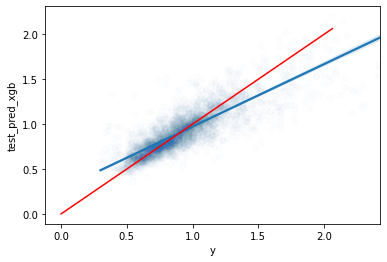

In [86]:
plot_RMSE_scatter(data = X_test,y_pred = 'test_pred_xgb')

<AxesSubplot:ylabel='Count'>

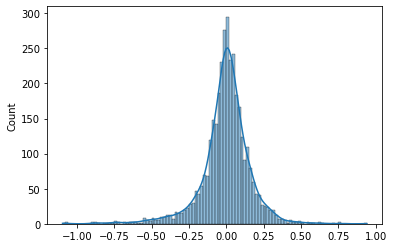

In [87]:
plot_RMSE_hist(data = X_test,  y_pred = 'test_pred_xgb')

## Example predictions

In [88]:
all_columns = X_test.columns

Create a function that we can use for prediction

In [89]:
def predict_an_apartment_price(
    
    address = 'Jakab József utca 17, xiii. kerulet',
    base_area = 45,
    balcony_size = 8,
    full_room_number = 1,
    half_room_number = 0,
    year_build = 2010,
    district = 'xiii',
    apt_type = 'tegla-epitesu-lakas',
    quality = 'újszerű',
    floor = 8,
    max_floor = 10,
    top_floor = 'nemtetőtéri',
    bathroom_and_toilet = 'egyhelyiségben',
    indoor_height = '3-',
    view = 'utcai',
    facing = 'nyugat',
    garden = 'nem',
    elevator = 'van',
    for_handicap = 'nincsmegadva'):
    
    data = {'adress' : [address],
       "base_area" : base_area,
        "balcony_size" : balcony_size,
        "area_wiht_balcony_sqm" : base_area + balcony_size * 0.5,
        "full_room_number" : full_room_number,
        "half_room_number" : half_room_number,
        "lat" : 0,
        "lng" : 0,
        "last_postcode" : 1.0,
        "year_build" : year_build,
        "floor" : floor,
        "max_floor" : max_floor,
        "district_i" : 0,
        "district_ii" : 0,
        "district_iii" : 0,
        "district_iv" : 0,
        "district_ix" : 0,
        "district_v" : 0,
        "district_vi" : 0,
        "district_vii" : 0,
        "district_viii" : 0,
        "district_x" : 0,
        "district_xi" : 0,
        "district_xii" : 0,
        "district_xiii" : 0,
        "district_xiv" : 0,
        "district_xix" : 0,
        "district_xv" : 0,
        "district_xvi" : 0,
        "district_xvii" : 0,
        "district_xviii" : 0,
        "district_xx" : 0,
        "district_xxi" : 0,
        "district_xxii" : 0,
        "district_xxiii" : 0,
        "apt_type_csuszozsalus-lakas" : 0,
        "apt_type_panel-lakas" : 0,
        "apt_type_tegla-epitesu-lakas" : 0,
        "quality_befejezetlen" : 0,
        "quality_felújítandó" : 0,
        "quality_felújított" : 0,
        "quality_jóállapotú" : 0,
        "quality_közepesállapotú" : 0,
        "quality_nincsmegadva" : 0,
        "quality_újszerű" : 0,
        "quality_újépítésű" : 0,
        "top_floor_legfelsőemeletnemtetőtéri" : 0,
        "top_floor_nemtetőtéri" : 0,
        "top_floor_nincsmegadva" : 0,
        "top_floor_penthouse" : 0,
        "top_floor_tetőtéri" : 0,
        "top_floor_zárószint" : 0,
        "bathroom_and_toilet_egyhelyiségben" : 0,
        "bathroom_and_toilet_különhelyiségben" : 0,
        "bathroom_and_toilet_különésegybenis" : 0,
        "bathroom_and_toilet_nincsmegadva" : 0,
        "indoor_height_3+" : 0,
        "indoor_height_3-" : 0,
        "indoor_height_nincsmegadva" : 0,
        "view_kertrenéz" : 0,
        "view_nincsmegadva" : 0,
        "view_panorámás" : 0,
        "view_udvari" : 0,
        "view_utcai" : 0,
        "facing_dél" : 0,
        "facing_délkelet" : 0,
        "facing_délnyugat" : 0,
        "facing_kelet" : 0,
        "facing_nincsmegadva" : 0,
        "facing_nyugat" : 0,
        "facing_észak" : 0,
        "facing_északkelet" : 0,
        "facing_északnyugat" : 0,
        "garden_igen" : 0,
        "garden_nem" : 0,
        "garden_nincsmegadva" : 0,
        "elevator_nincs" : 0,
        "elevator_nincsmegadva" : 0,
        "elevator_van" : 0,
        "for_handicap_igen" : 0,
        "for_handicap_nem" : 0,
        "for_handicap_nincsmegadva" : 0}

    predict_this_base = pd.DataFrame(data)
    
    prefix_search = ['district', 'apt_type', 'quality', 'top_floor', 'bathroom_and_toilet', 'indoor_height', 'view', 'facing', 'garden', 'elevator', 'for_handicap']

    values_search = [district, apt_type, quality, top_floor, bathroom_and_toilet, indoor_height, view, facing, garden, elevator, for_handicap]

    def modify_column_values(data = predict_this_base, col_names_to_check = [], prefixs = prefix_search, values = values_search):   
    
        data_new = data
    
        for i in range(len(prefixs)):
            colum_to_modify = str(prefixs[i] + '_' + str(values_search[i]))
            data_new[colum_to_modify] = 1

        return(data_new)
    
    predict_this = modify_column_values(data = predict_this_base)
    
    predict_this_coord = get_coordinates_for_addresses(data = predict_this_base, address_column_name = 'adress', save_csv=False, limit = 1)
    predict_this_coord['last_postcode'] = predict_this_coord['postcode'].astype(str).str.strip().str[-1]
    predict_this_coord['last_postcode'] = predict_this_coord['last_postcode'].astype('float')

    try:
        predict_this['lat'] = predict_this_coord['lat'][0]
        predict_this['lng'] = predict_this_coord['lng'][0]
        predict_this['last_postcode'] = predict_this_coord['last_postcode'][0]
    except:
        predict_this['lat'] = 0
        predict_this['lng'] = 0
        predict_this['last_postcode'] = 0.0
    
    predict_this_distance = create_distances_from_local_points(data_original_coordinates = predict_this)
    
    predict_this = pd.merge(predict_this, predict_this_distance, left_on= ['lat', 'lng'], right_on=['lat', 'lng'], how = 'left')

    predict_this_only_this_columns = ['adress', 'base_area', 'balcony_size', 'area_wiht_balcony_sqm',
    'full_room_number', 'half_room_number', 'lat', 'lng', 'last_postcode',
    'year_build', 'floor', 'max_floor', 'district_i', 'district_ii',
    'district_iii', 'district_iv', 'district_ix', 'district_v',
    'district_vi', 'district_vii', 'district_viii', 'district_x',
    'district_xi', 'district_xii', 'district_xiii', 'district_xiv',
    'district_xix', 'district_xv', 'district_xvi', 'district_xvii',
    'district_xviii', 'district_xx', 'district_xxi', 'district_xxii',
    'district_xxiii', 'apt_type_csuszozsalus-lakas', 'apt_type_panel-lakas',
    'apt_type_tegla-epitesu-lakas', 'quality_befejezetlen',
    'quality_felújítandó', 'quality_felújított', 'quality_jóállapotú',
    'quality_közepesállapotú', 'quality_nincsmegadva', 'quality_újszerű',
    'quality_újépítésű', 'top_floor_legfelsőemeletnemtetőtéri',
    'top_floor_nemtetőtéri', 'top_floor_nincsmegadva',
    'top_floor_penthouse', 'top_floor_tetőtéri', 'top_floor_zárószint',
    'bathroom_and_toilet_egyhelyiségben',
    'bathroom_and_toilet_különhelyiségben',
    'bathroom_and_toilet_különésegybenis',
    'bathroom_and_toilet_nincsmegadva', 'indoor_height_3+',
    'indoor_height_3-', 'indoor_height_nincsmegadva', 'view_kertrenéz',
    'view_nincsmegadva', 'view_panorámás', 'view_udvari', 'view_utcai',
    'facing_dél', 'facing_délkelet', 'facing_délnyugat', 'facing_kelet',
    'facing_nincsmegadva', 'facing_nyugat', 'facing_észak',
    'facing_északkelet', 'facing_északnyugat', 'garden_igen', 'garden_nem',
    'garden_nincsmegadva', 'elevator_nincs', 'elevator_nincsmegadva',
    'elevator_van', 'for_handicap_igen', 'for_handicap_nem',
    'for_handicap_nincsmegadva', 'korforgalom_distance']

    predict_this = predict_this[predict_this_only_this_columns]
    
    predicted_rf_sqrt_price = rf_model.predict(predict_this.drop(['adress'], axis=1))[0]
    predicted_rf_total_price = predict_this['area_wiht_balcony_sqm'][0] * predicted_rf_sqrt_price
    print("predicted RF sqm price: ",  predicted_rf_sqrt_price)
    print("predicted RF total price: ", predicted_rf_total_price)

    predicted_xgb_sqrt_price = xgb_model.predict(predict_this.drop(['adress'], axis=1))[0]
    predicted_xgb_total_price = predict_this['area_wiht_balcony_sqm'][0] * predicted_xgb_sqrt_price
    print("predicted XGB sqm price: ",  predicted_xgb_sqrt_price)
    print("predicted XGB total price: ", predicted_xgb_total_price)

    return(predicted_rf_sqrt_price, predicted_rf_total_price, predicted_xgb_sqrt_price, predicted_xgb_total_price, predict_this)

In [90]:
predicted_price = predict_an_apartment_price(

    address = 'Jakab József utca, xiii. kerulet',
    base_area = 45,
    balcony_size = 8,
    full_room_number = 1,
    half_room_number = 0,
    year_build = 2010,
    district = 'xiii',
    apt_type = 'tegla-epitesu-lakas',
    quality = 'jóállapotú',
    floor = 8,
    max_floor = 9,
    top_floor = 'nemtetőtéri',
    bathroom_and_toilet = 'egyhelyiségben',
    indoor_height = '3-',
    view = 'utcai',
    facing = 'északnyugat',
    garden = 'nem',
    elevator = 'van',
    for_handicap = 'nincsmegadva'

)

predicted_price[4]

Progress: 100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


predicted RF sqm price:  0.8091272648146078
predicted RF total price:  39.647235975915784
predicted XGB sqm price:  1.2762728
predicted XGB total price:  62.53736591339111


,adress,base_area,balcony_size,area_wiht_balcony_sqm,full_room_number,half_room_number,lat,lng,last_postcode,year_build,floor,max_floor,district_i,district_ii,district_iii,district_iv,district_ix,district_v,district_vi,district_vii,district_viii,district_x,district_xi,district_xii,district_xiii,district_xiv,district_xix,district_xv,district_xvi,district_xvii,district_xviii,district_xx,district_xxi,district_xxii,district_xxiii,apt_type_csuszozsalus-lakas,apt_type_panel-lakas,apt_type_tegla-epitesu-lakas,quality_befejezetlen,quality_felújítandó,quality_felújított,quality_jóállapotú,quality_közepesállapotú,quality_nincsmegadva,quality_újszerű,quality_újépítésű,top_floor_legfelsőemeletnemtetőtéri,top_floor_nemtetőtéri,top_floor_nincsmegadva,top_floor_penthouse,top_floor_tetőtéri,top_floor_zárószint,bathroom_and_toilet_egyhelyiségben,bathroom_and_toilet_különhelyiségben,bathroom_and_toilet_különésegybenis,bathroom_and_toilet_nincsmegadva,indoor_height_3+,indoor_height_3-,indoor_height_nincsmegadva,view_kertrenéz,view_nincsmegadva,view_panorámás,view_udvari,view_utcai,facing_dél,facing_délkelet,facing_délnyugat,facing_kelet,facing_nincsmegadva,facing_nyugat,facing_észak,facing_északkelet,facing_északnyugat,garden_igen,garden_nem,garden_nincsmegadva,elevator_nincs,elevator_nincsmegadva,elevator_van,for_handicap_igen,for_handicap_nem,for_handicap_nincsmegadva,korforgalom_distance
0,"Jakab József utca, xiii. kerulet",45,8,49.0,1,0,47.537004,19.063797,8.0,2010,8,9,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,4700


In [98]:
predicted_price = predict_an_apartment_price(
    address = 'Csányi utca, vi. kerulet',
    base_area = 45,
    balcony_size = 4,
    full_room_number = 1,
    half_room_number = 0,
    year_build = 2015,
    district = 'vi',
    apt_type = 'tegla-epitesu-lakas',
    quality = 'jóállapotú',
    floor = 4,
    max_floor = 8,
    top_floor = 'nemtetőtéri',
    bathroom_and_toilet = 'egyhelyiségben',
    indoor_height = '3-',
    view = 'udvari',
    facing = 'északnyugat',
    garden = 'nem',
    elevator = 'van',
    for_handicap = 'nincsmegadva'
)

predicted_price[4]

Progress: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]

predicted RF sqm price:  1.6443462677425735
predicted RF total price:  77.28427458390095
predicted XGB sqm price:  1.6374515
predicted XGB total price:  76.96022188663483


,adress,base_area,balcony_size,area_wiht_balcony_sqm,full_room_number,half_room_number,lat,lng,last_postcode,year_build,floor,max_floor,district_i,district_ii,district_iii,district_iv,district_ix,district_v,district_vi,district_vii,district_viii,district_x,district_xi,district_xii,district_xiii,district_xiv,district_xix,district_xv,district_xvi,district_xvii,district_xviii,district_xx,district_xxi,district_xxii,district_xxiii,apt_type_csuszozsalus-lakas,apt_type_panel-lakas,apt_type_tegla-epitesu-lakas,quality_befejezetlen,quality_felújítandó,quality_felújított,quality_jóállapotú,quality_közepesállapotú,quality_nincsmegadva,quality_újszerű,quality_újépítésű,top_floor_legfelsőemeletnemtetőtéri,top_floor_nemtetőtéri,top_floor_nincsmegadva,top_floor_penthouse,top_floor_tetőtéri,top_floor_zárószint,bathroom_and_toilet_egyhelyiségben,bathroom_and_toilet_különhelyiségben,bathroom_and_toilet_különésegybenis,bathroom_and_toilet_nincsmegadva,indoor_height_3+,indoor_height_3-,indoor_height_nincsmegadva,view_kertrenéz,view_nincsmegadva,view_panorámás,view_udvari,view_utcai,facing_dél,facing_délkelet,facing_délnyugat,facing_kelet,facing_nincsmegadva,facing_nyugat,facing_észak,facing_északkelet,facing_északnyugat,garden_igen,garden_nem,garden_nincsmegadva,elevator_nincs,elevator_nincsmegadva,elevator_van,for_handicap_igen,for_handicap_nem,for_handicap_nincsmegadva,korforgalom_distance
0,"Csányi utca, vi. kerulet",45,4,47.0,1,0,47.500517,19.063788,2.0,2015,4,8,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,1800


In [95]:
predicted_price = predict_an_apartment_price(
    
    address = 'Bihari János utca, v. kerület',
    base_area = 107,
    balcony_size = 0,
    full_room_number = 3,
    half_room_number = 0,
    year_build = 1950,
    district = 'v',
    apt_type = 'tegla-epitesu-lakas',
    quality = 'újszerű',
    floor = 1,
    max_floor = 4,
    top_floor = 'nemtetőtéri',
    bathroom_and_toilet = 'különésegybenis',
    indoor_height = '3+',
    view = 'udvari',
    facing = 'délnyugat',
    garden = 'nem',
    elevator = 'van',
    for_handicap = 'nincsmegadva'
)

predicted_price[4]

Progress: 100%|██████████| 1/1 [00:00<00:00,  7.58it/s]


predicted RF sqm price:  0.6508571004397986
predicted RF total price:  69.64170974705846
predicted XGB sqm price:  1.1569569
predicted XGB total price:  123.79438948631287


,adress,base_area,balcony_size,area_wiht_balcony_sqm,full_room_number,half_room_number,lat,lng,last_postcode,year_build,floor,max_floor,district_i,district_ii,district_iii,district_iv,district_ix,district_v,district_vi,district_vii,district_viii,district_x,district_xi,district_xii,district_xiii,district_xiv,district_xix,district_xv,district_xvi,district_xvii,district_xviii,district_xx,district_xxi,district_xxii,district_xxiii,apt_type_csuszozsalus-lakas,apt_type_panel-lakas,apt_type_tegla-epitesu-lakas,quality_befejezetlen,quality_felújítandó,quality_felújított,quality_jóállapotú,quality_közepesállapotú,quality_nincsmegadva,quality_újszerű,quality_újépítésű,top_floor_legfelsőemeletnemtetőtéri,top_floor_nemtetőtéri,top_floor_nincsmegadva,top_floor_penthouse,top_floor_tetőtéri,top_floor_zárószint,bathroom_and_toilet_egyhelyiségben,bathroom_and_toilet_különhelyiségben,bathroom_and_toilet_különésegybenis,bathroom_and_toilet_nincsmegadva,indoor_height_3+,indoor_height_3-,indoor_height_nincsmegadva,view_kertrenéz,view_nincsmegadva,view_panorámás,view_udvari,view_utcai,facing_dél,facing_délkelet,facing_délnyugat,facing_kelet,facing_nincsmegadva,facing_nyugat,facing_észak,facing_északkelet,facing_északnyugat,garden_igen,garden_nem,garden_nincsmegadva,elevator_nincs,elevator_nincsmegadva,elevator_van,for_handicap_igen,for_handicap_nem,for_handicap_nincsmegadva,korforgalom_distance
0,"Bihari János utca, v. kerület",107,0,107.0,3,0,47.50893,19.053655,4.0,1950,1,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1600
